In [1]:
# Install specific libraries
!pip install transformers
!pip install wordcloud
!pip install --upgrade scikit-learn
!pip install optuna
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 82.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
# Import libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from pylab import rcParams
import transformers
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, BertTokenizerFast, BertForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import optuna
from tqdm import tqdm 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [3]:
# Specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Set seeds for reproducibility
SEED_VALUE = 42
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_VALUE)

In [5]:
# Load Dataset
true_data = pd.read_csv('/kaggle/input/newsdataset/True.csv')
fake_data = pd.read_csv('/kaggle/input/newsdataset/Fake.csv')

# Combine datasets and add a label column
true_data['label'] = 0
fake_data['label'] = 1
data = pd.concat([fake_data, true_data], ignore_index=True)

In [6]:
# We observe that there are 209 news that are duplicated, hence we will be dropping them.
print(data.duplicated().sum())
print("Before removing:")
data.describe()

209
Before removing:


,label
count,44898.000000
mean,0.522985
std,0.499477
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
data.drop_duplicates(inplace=True)
print(data.duplicated().sum())
print("After removing:")
data.describe()

0
After removing:


,label
count,44689.000000
mean,0.525364
std,0.499362
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


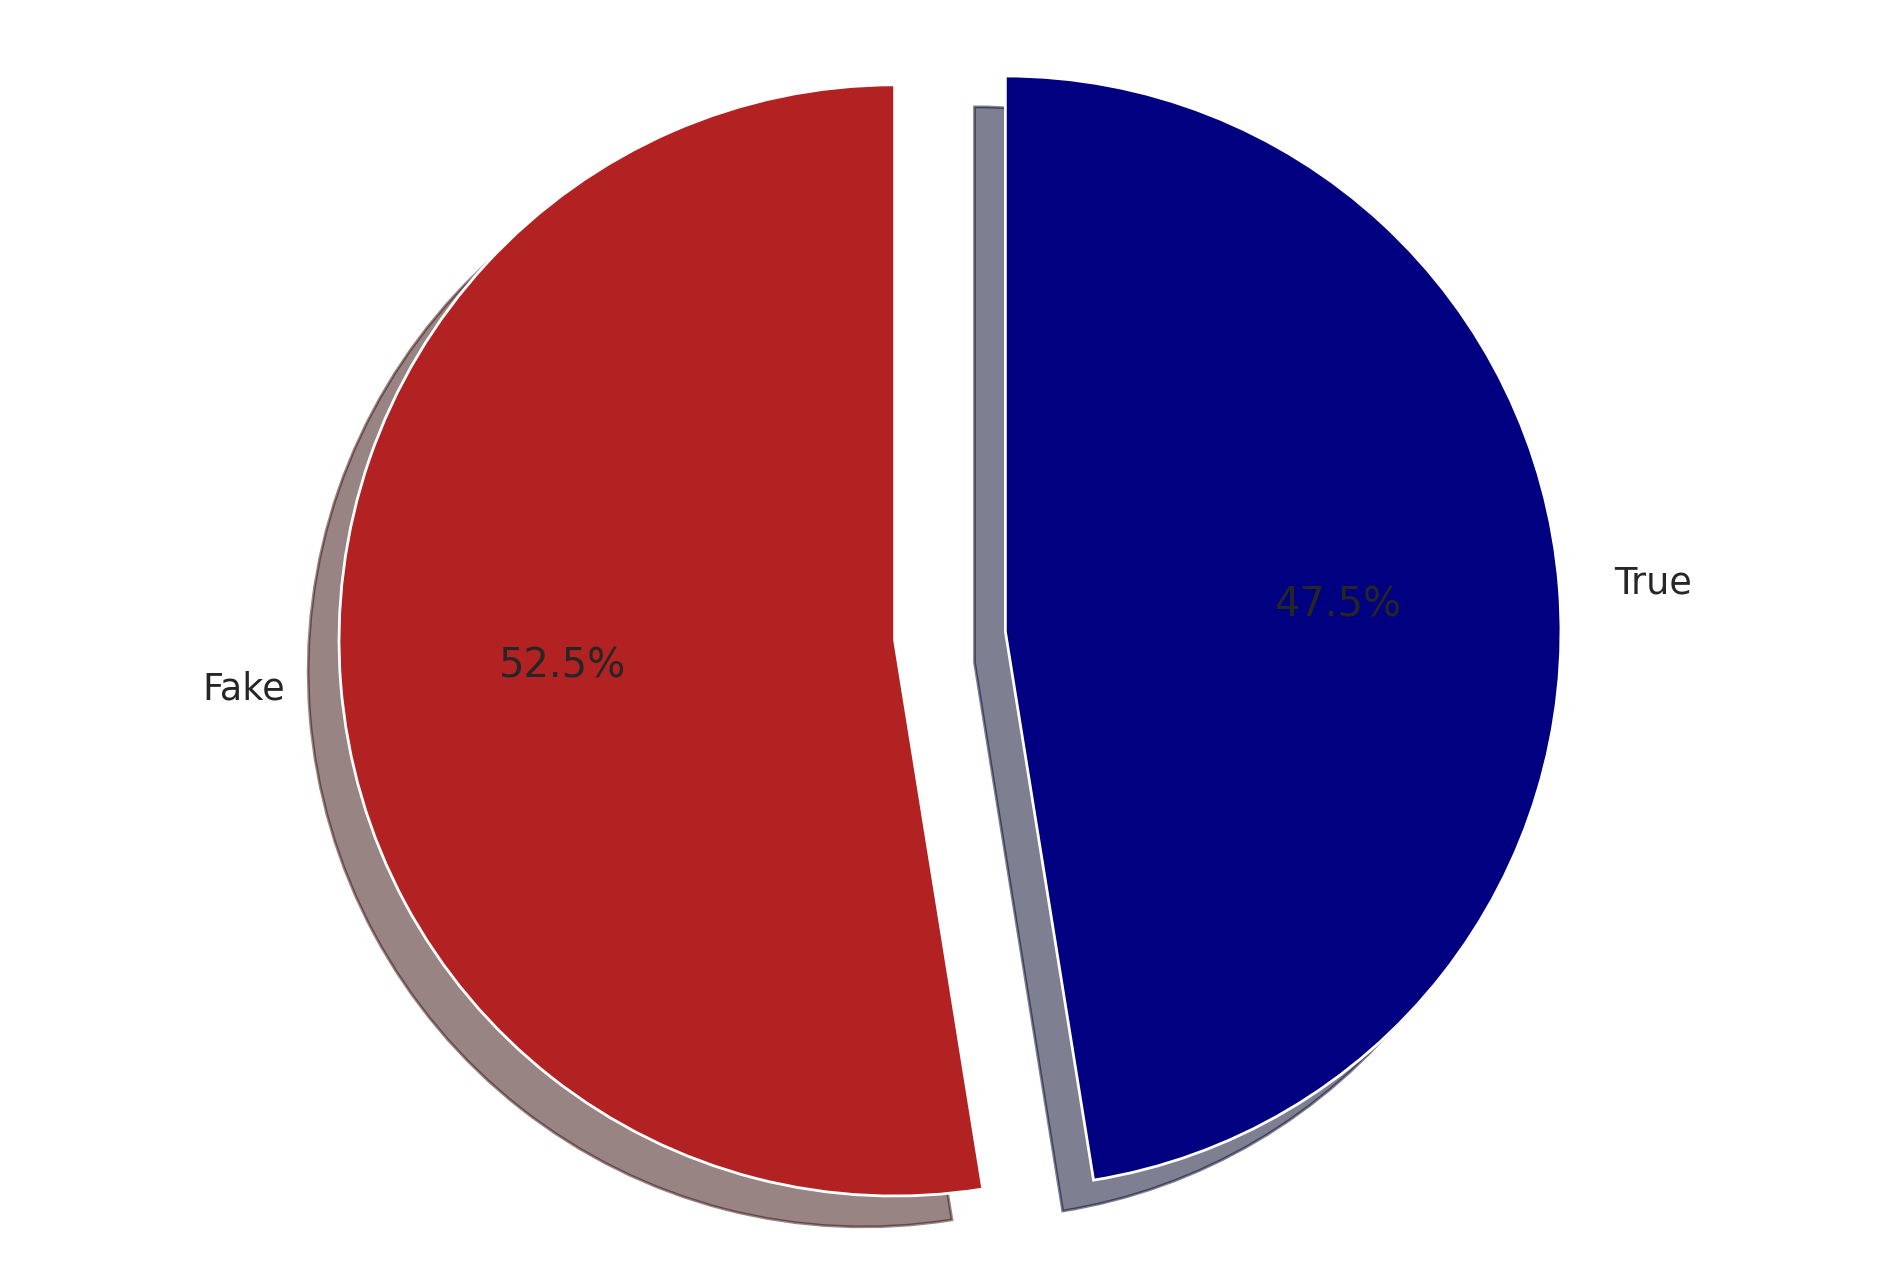

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  
label
1    23478
0    21211
Name: count, dtype: int64


In [8]:
# Checking if our data is well balanced
label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
plt.pie(label_size, 
         explode=[0.1, 0.1], 
         colors=['firebrick', 'navy'], 
         startangle=90, 
         shadow=True, 
         labels=['Fake', 'True'],
         autopct='%1.1f%%')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.show()

# Data Exploration
print(data.head())
print(data['label'].value_counts())

In [9]:
# Train-Validation-Test set split into 70:15:15 ratio
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], random_state=SEED_VALUE, test_size=0.3)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=SEED_VALUE, test_size=0.5)

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  
label
1    23478
0    21211
Name: count, dtype: int64


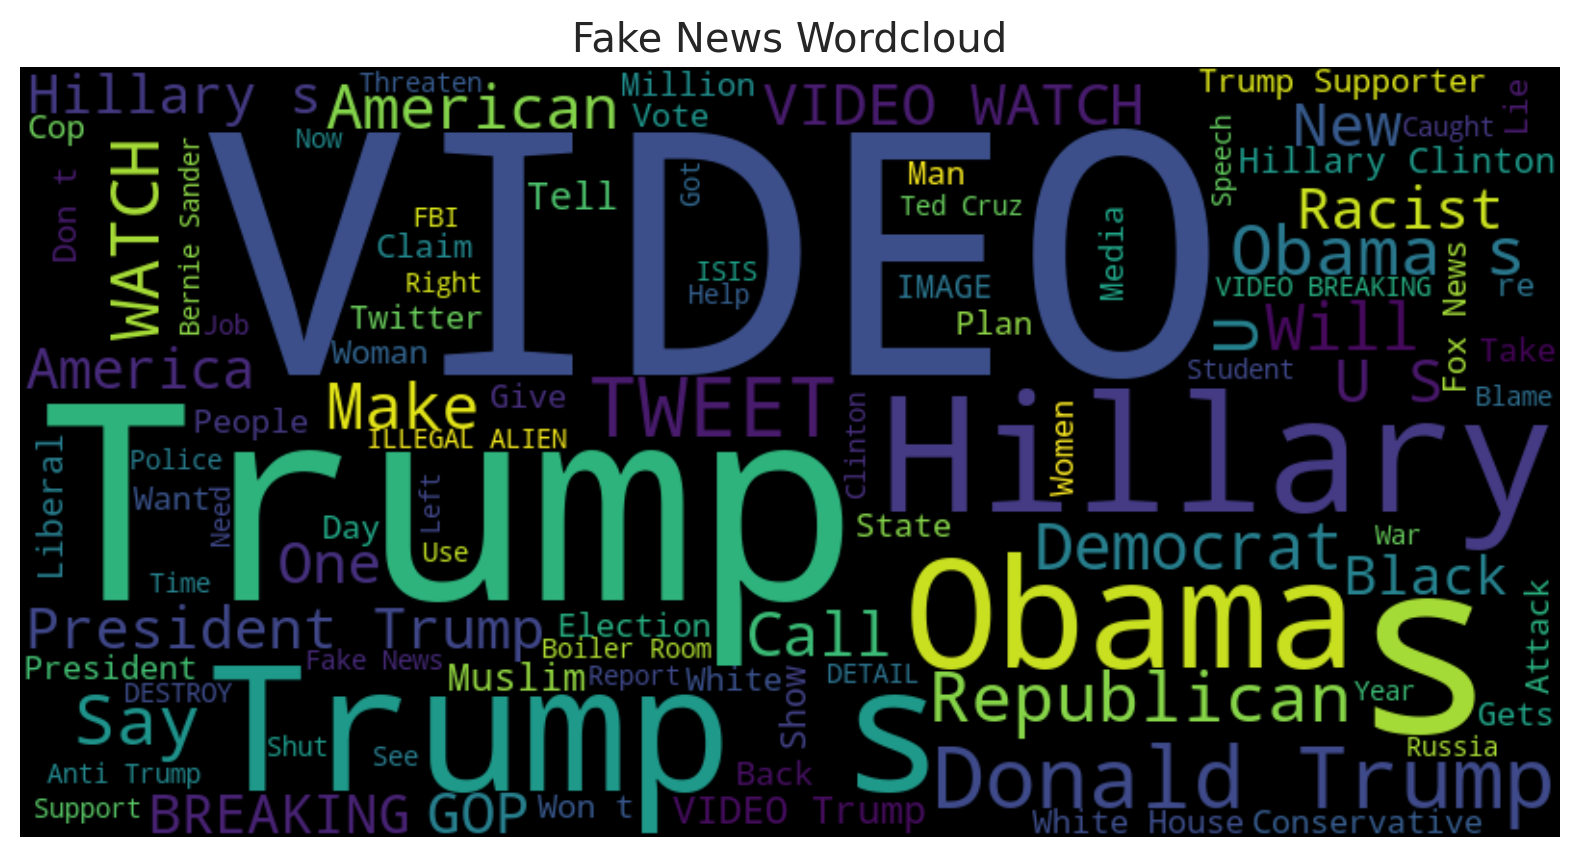

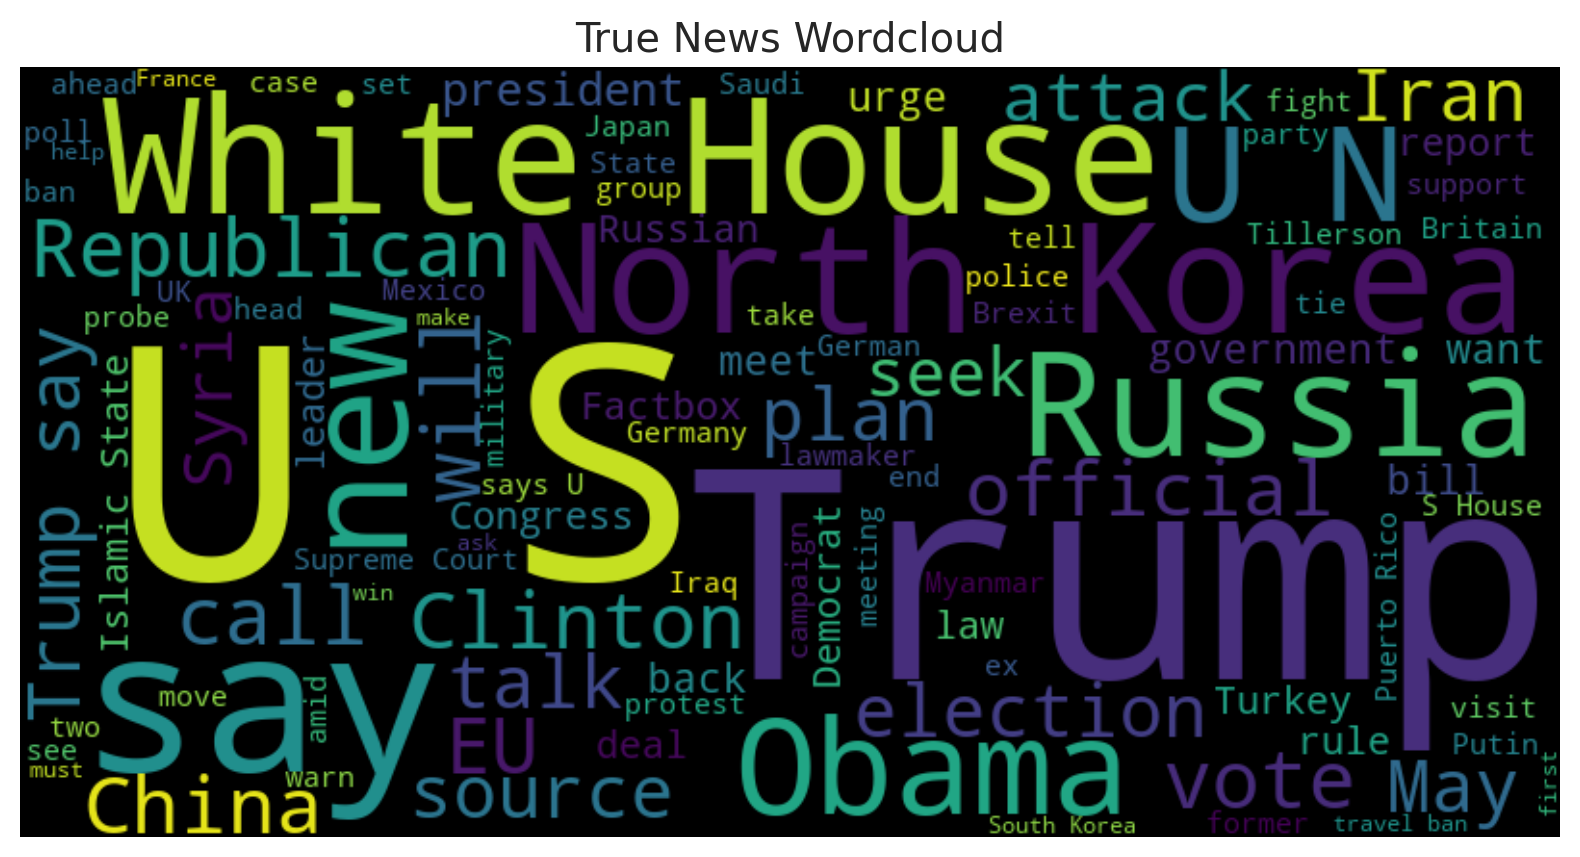

In [10]:
# Data Exploration
print(data.head())
print(data['label'].value_counts())

# Wordcloud for Fake and True News
fake_text = ' '.join(fake_data['title'])
true_text = ' '.join(true_data['title'])

fake_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(fake_text)
true_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(true_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News Wordcloud')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('True News Wordcloud')
plt.show()

Text(0, 0.5, 'Number of texts')

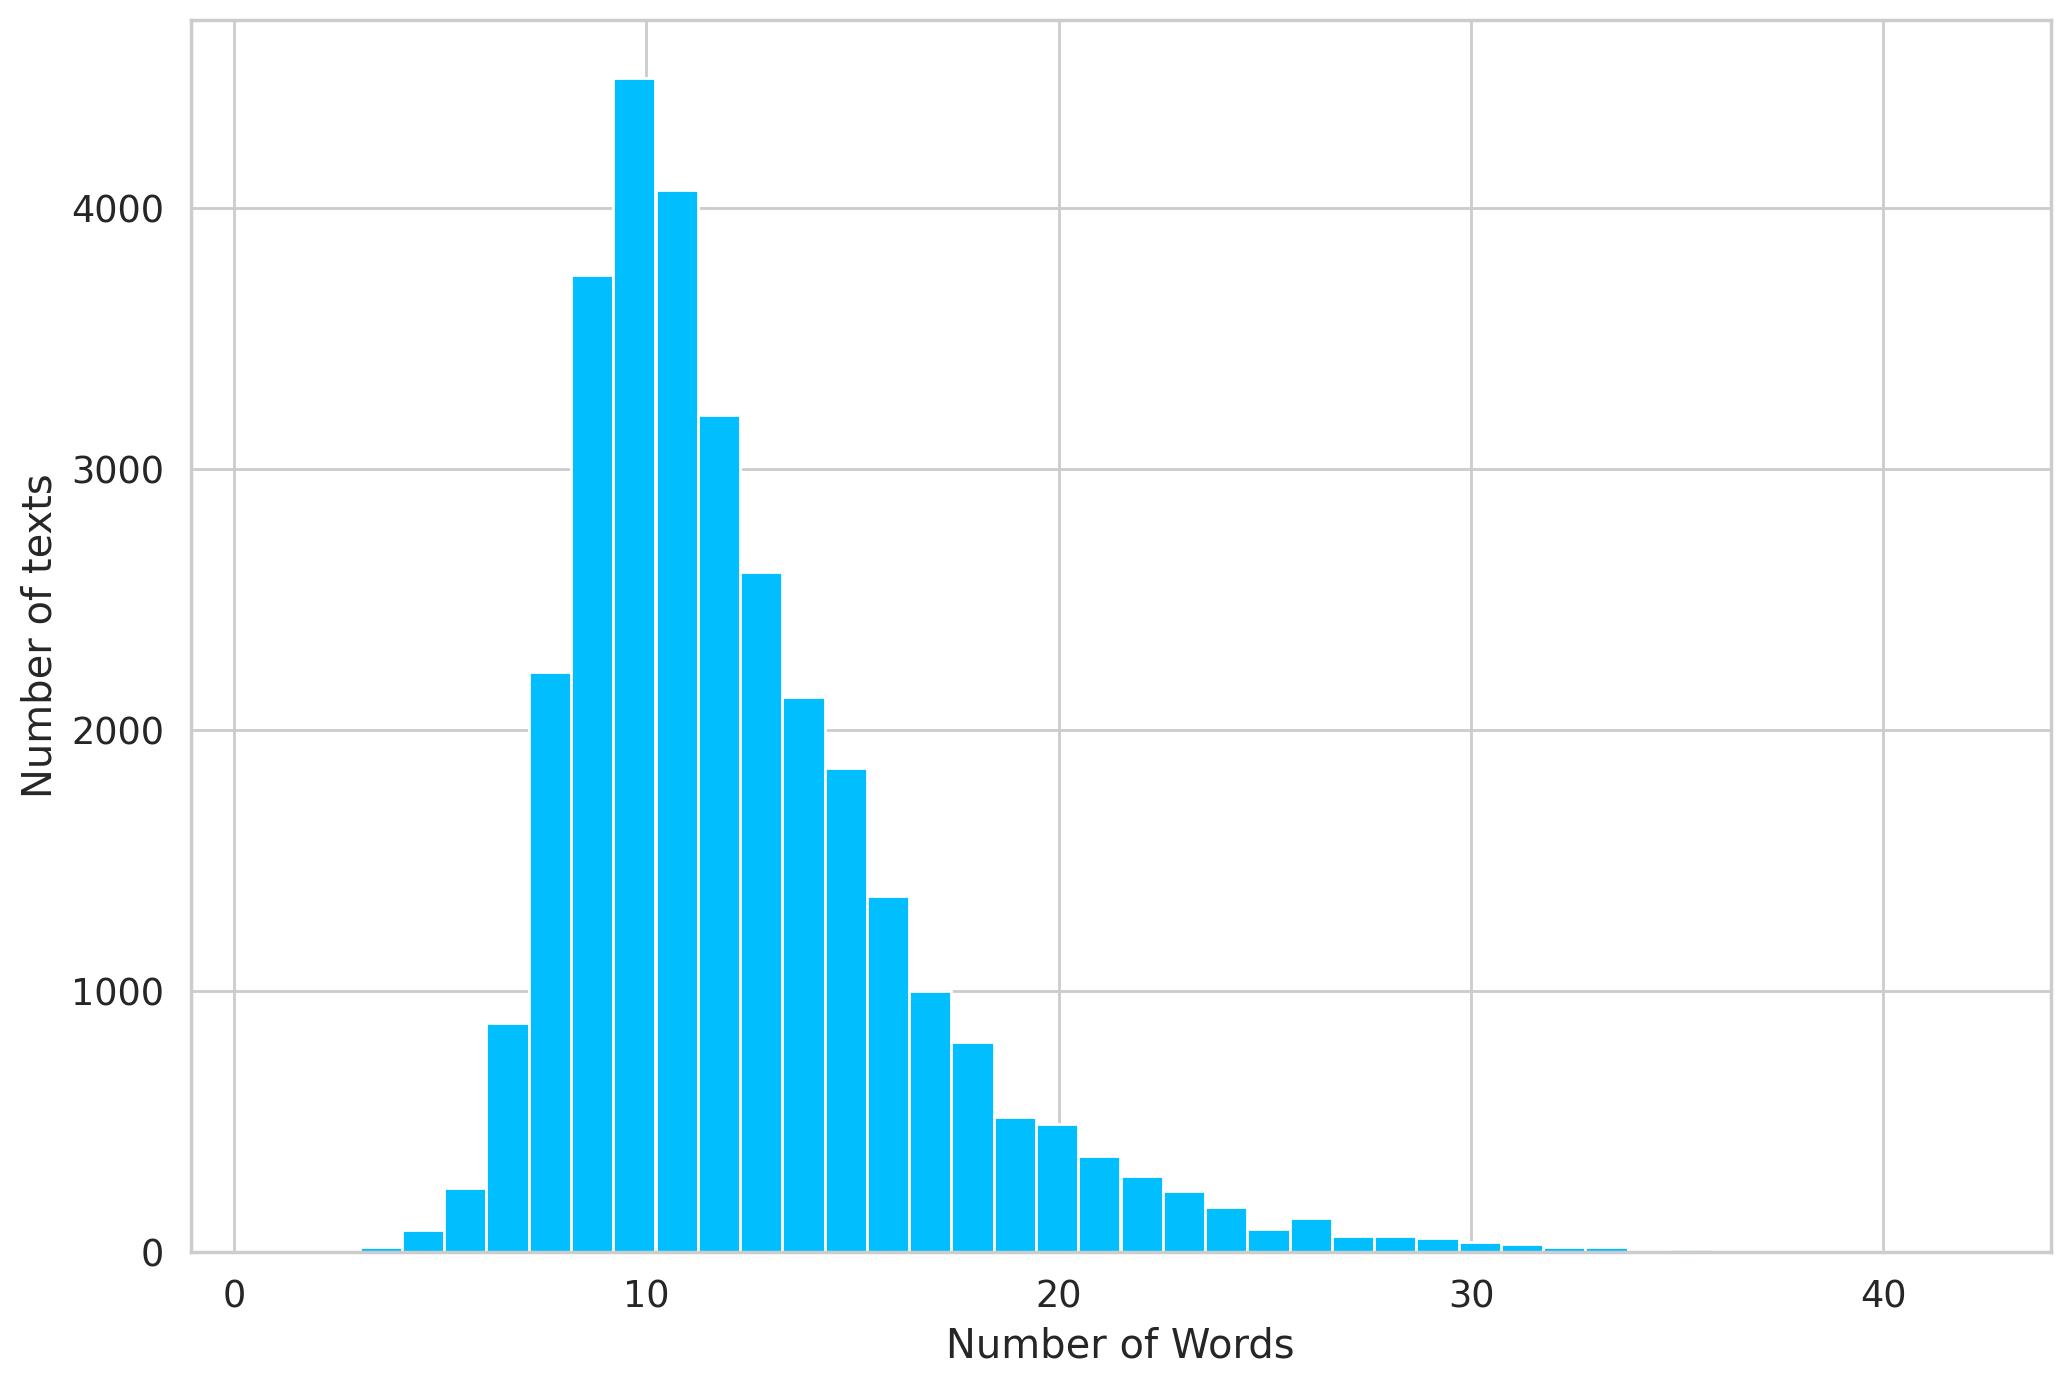

In [11]:
# Plot histogram of the number of words in train data 'text'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40)
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Maximum token length: 63


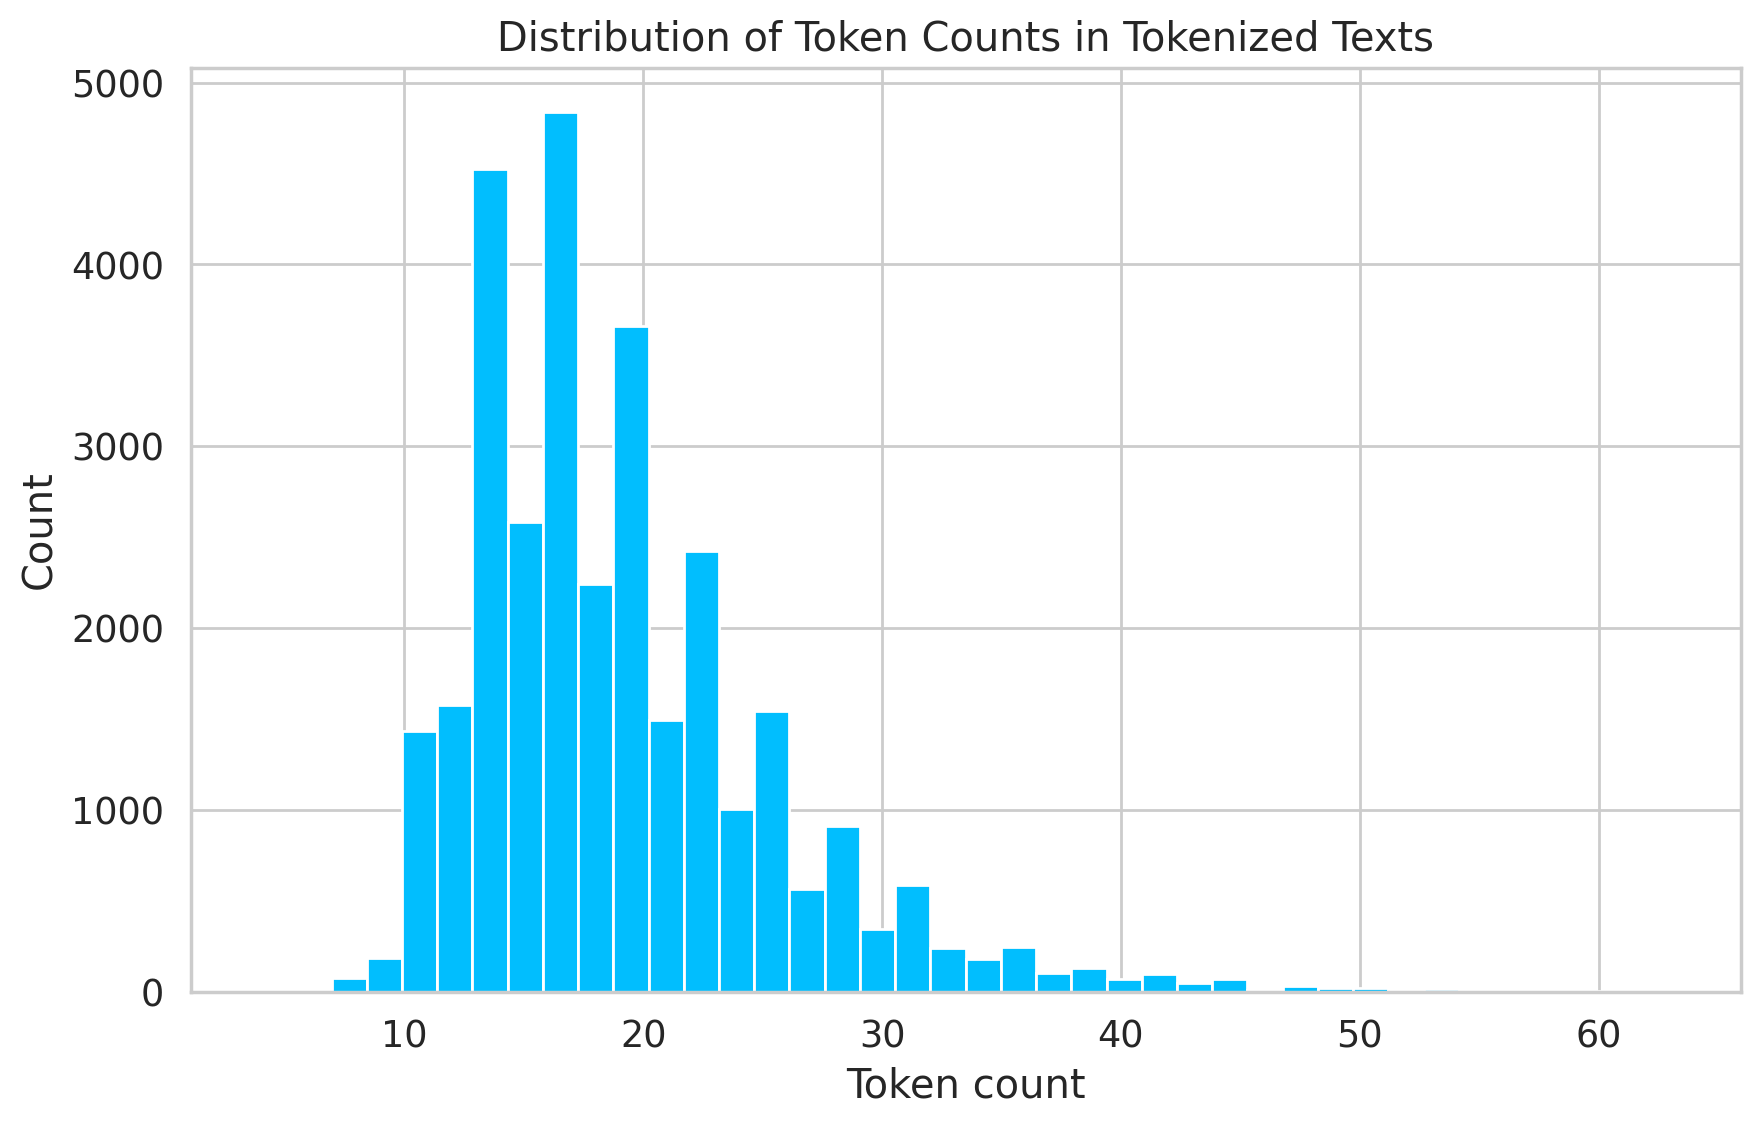

In [12]:
# Load tokenizer for a specific BERT model (replace with the desired model)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the text and get token counts
token_lens = [len(tokenizer(title, truncation=True, padding=False)['input_ids']) for title in train_text]

print("Maximum token length:",max(token_lens))

# Plot histogram of token counts
plt.figure(figsize=(10, 6))
pd.Series(token_lens).hist(bins=40)
plt.xlabel('Token count')
plt.ylabel('Count')
plt.title('Distribution of Token Counts in Tokenized Texts')
plt.show()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Maximum token length: 94


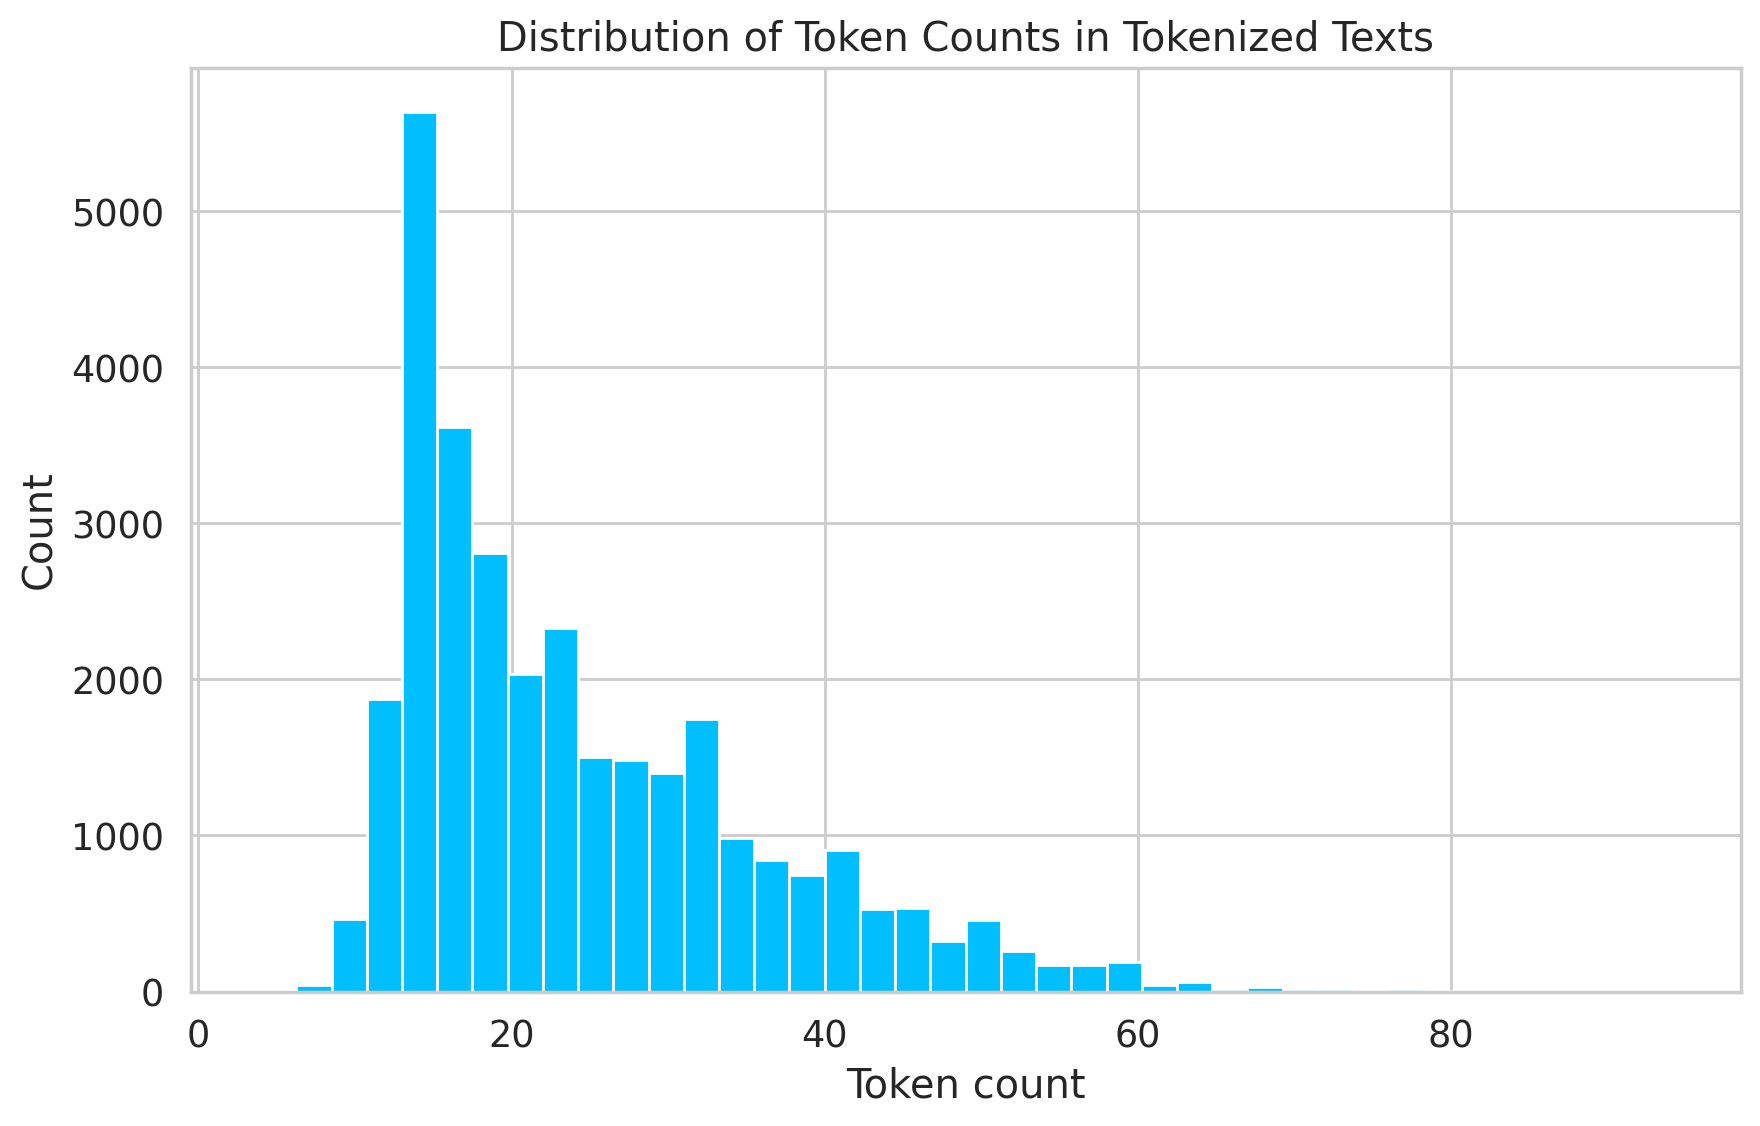

In [13]:
# Load tokenizer for a specific BERT model (replace with the desired model)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

# Tokenize the text and get token counts
token_lens = [len(tokenizer(title, truncation=True, padding=False)['input_ids']) for title in train_text]

print("Maximum token length:",max(token_lens))

# Plot histogram of token counts
plt.figure(figsize=(10, 6))
pd.Series(token_lens).hist(bins=40)
plt.xlabel('Token count')
plt.ylabel('Count')
plt.title('Distribution of Token Counts in Tokenized Texts')
plt.show()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Maximum token length: 63


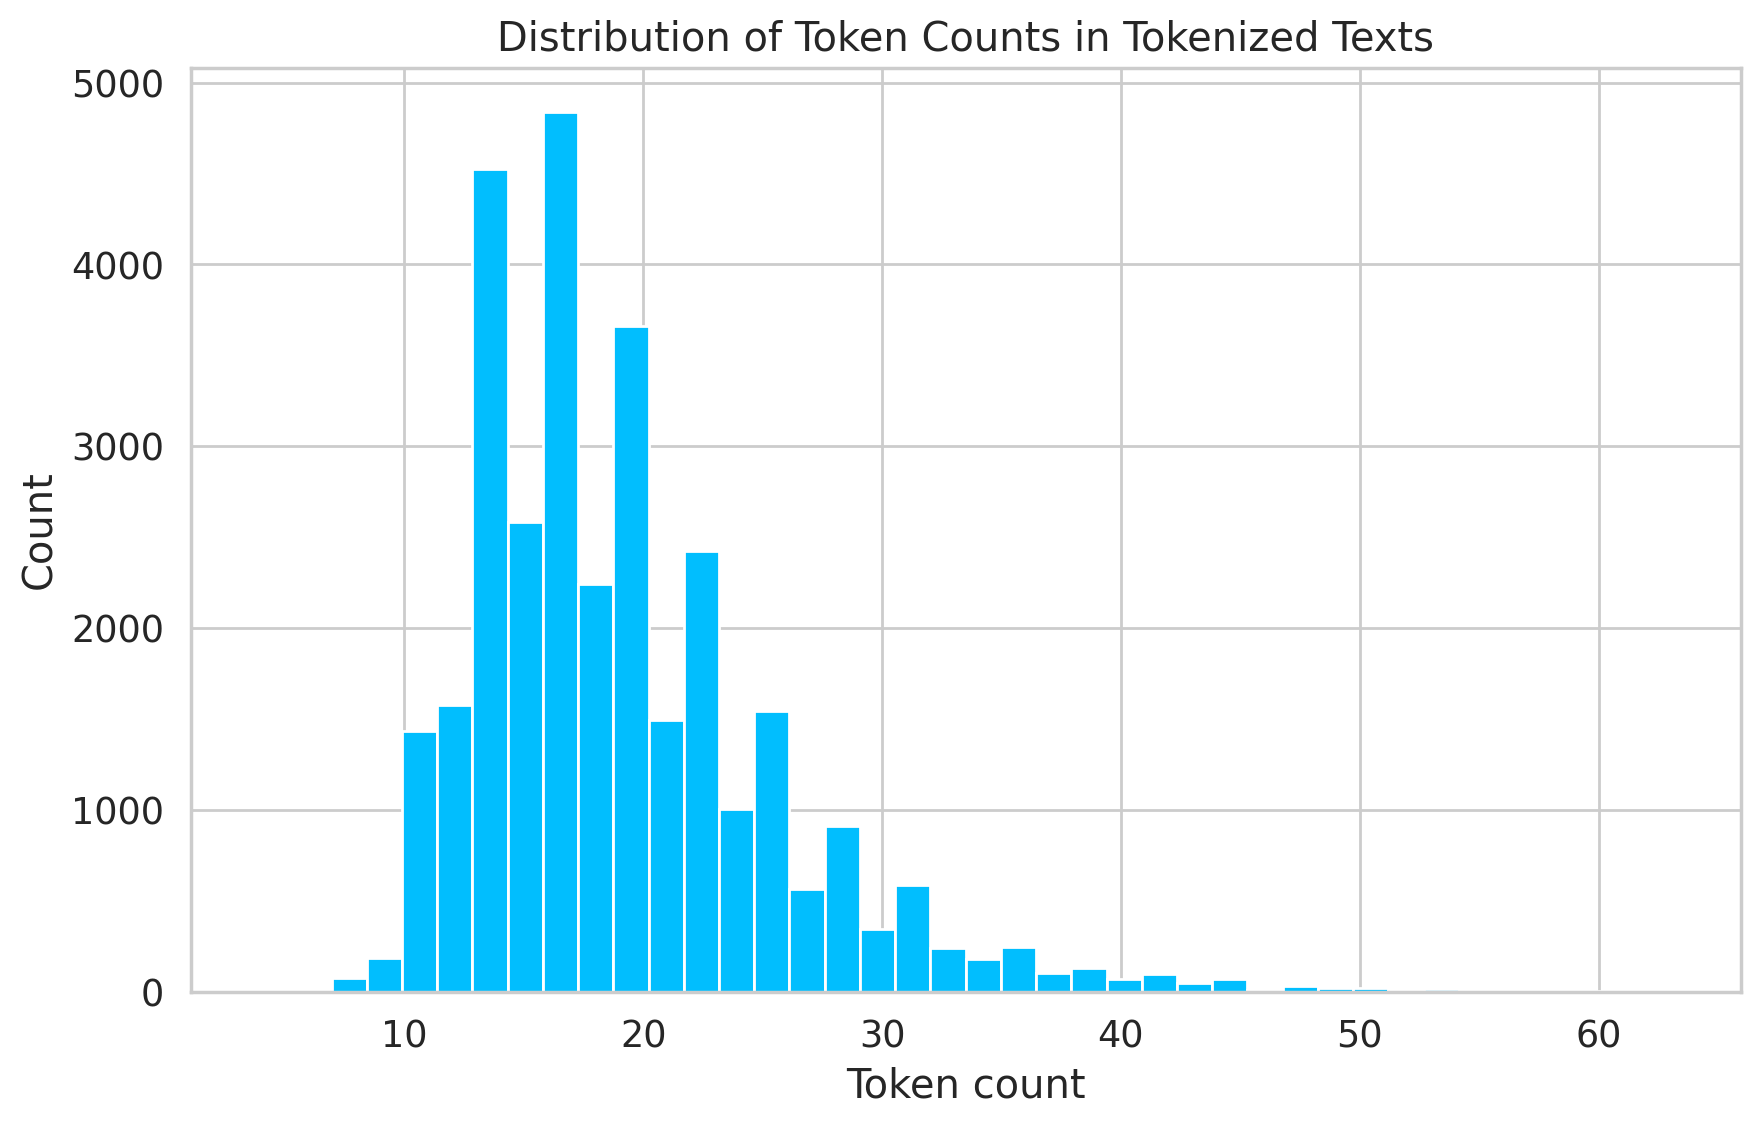

In [14]:
# Load tokenizer for a specific BERT model (replace with the desired model)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize the text and get token counts
token_lens = [len(tokenizer(title, truncation=True, padding=False)['input_ids']) for title in train_text]

print("Maximum token length:",max(token_lens))

# Plot histogram of token counts
plt.figure(figsize=(10, 6))
pd.Series(token_lens).hist(bins=40)
plt.xlabel('Token count')
plt.ylabel('Count')
plt.title('Distribution of Token Counts in Tokenized Texts')
plt.show()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Maximum token length: 94


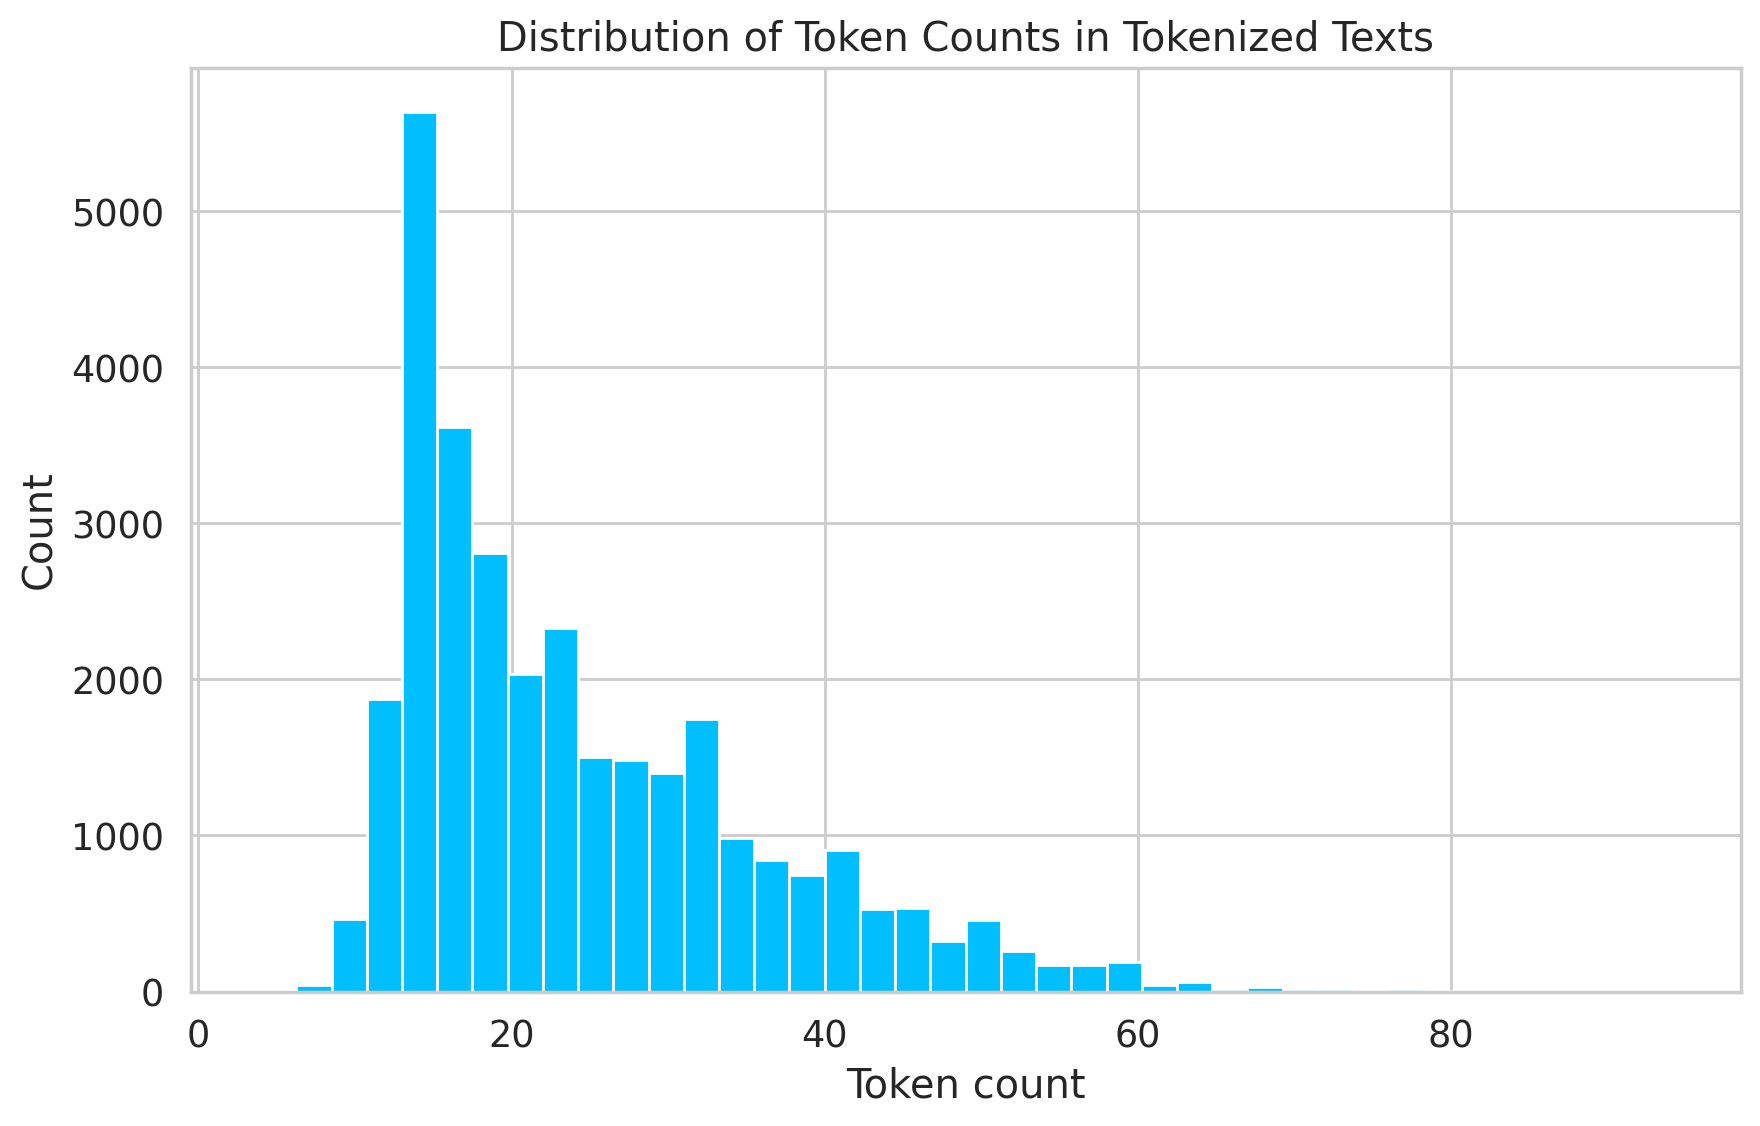

In [15]:
# Load tokenizer for a specific BERT model (replace with the desired model)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# Tokenize the text and get token counts
token_lens = [len(tokenizer(title, truncation=True, padding=False)['input_ids']) for title in train_text]

print("Maximum token length:",max(token_lens))

# Plot histogram of token counts
plt.figure(figsize=(10, 6))
pd.Series(token_lens).hist(bins=40)
plt.xlabel('Token count')
plt.ylabel('Count')
plt.title('Distribution of Token Counts in Tokenized Texts')
plt.show()

In [16]:
# Function to load tokenizer and model
def load_model_and_tokenizer(model_name):
    if model_name == 'distilbert':
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    elif model_name == 'distilbert-cased':
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
    elif model_name == 'bert-base-cased':
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
        model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
    elif model_name == 'bert-base-uncased':
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    return tokenizer, model

In [17]:
# Max length for models (the majority of titles have word length under 100 so set the MAX_LENGTH to 128 to provide some buffer)
MAX_LENGTH = 128

In [18]:
# Tokenize and encode sequences in the train, validation, and test sets
def tokenize_data(tokenizer, texts):
    return tokenizer.batch_encode_plus(texts, max_length=MAX_LENGTH, padding='max_length', truncation=True)

In [19]:
# Convert lists to tensors for each variant
def convert_to_tensors(tokens, labels):
    return (
        torch.tensor(tokens['input_ids']),
        torch.tensor(tokens['attention_mask']),
        torch.tensor(labels.tolist())
    )

In [20]:
# Load and tokenize data for each model
model_variants = ['distilbert', 'distilbert-cased', 'bert-base-cased', 'bert-base-uncased']
tokens = {}
for variant in model_variants:
    tokenizer, model = load_model_and_tokenizer(variant)
    tokens[variant] = {
        'train': tokenize_data(tokenizer, train_text.tolist()),
        'val': tokenize_data(tokenizer, val_text.tolist()),
        'test': tokenize_data(tokenizer, test_text.tolist()),
    }

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Convert to tensors
tensor_data = {}
for variant in model_variants:
    train_seq, train_mask, train_y = convert_to_tensors(tokens[variant]['train'], train_labels)
    val_seq, val_mask, val_y = convert_to_tensors(tokens[variant]['val'], val_labels)
    test_seq, test_mask, test_y = convert_to_tensors(tokens[variant]['test'], test_labels)
    tensor_data[variant] = {
        'train': (train_seq, train_mask, train_y),
        'val': (val_seq, val_mask, val_y),
        'test': (test_seq, test_mask, test_y)
    }

In [22]:
def create_data_loader(seq, mask, labels, batch_size):
    data = TensorDataset(seq, mask, labels)
    sampler = RandomSampler(data)
    return DataLoader(data, sampler=sampler, batch_size=batch_size)

In [23]:
# Define hyperparameters for tuning
def objective(trial):
    model_name = trial.suggest_categorical('model_name', model_variants)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    epochs = trial.suggest_int('epochs', 5, 10)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    warmup_steps = trial.suggest_int('warmup_steps', 0, 100)

    train_dataloader = create_data_loader(*tensor_data[model_name]['train'], batch_size)
    val_dataloader = create_data_loader(*tensor_data[model_name]['val'], batch_size)

    model = load_model_and_tokenizer(model_name)[1]
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    total_steps = len(train_dataloader) * epochs
    scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{epochs}'):
            batch = [b.to(device) for b in batch]
            sent_id, mask, labels = batch
            model.zero_grad()
            preds = model(sent_id, attention_mask=mask).logits
            loss = nn.CrossEntropyLoss()(preds, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f'Validation Epoch {epoch + 1}/{epochs}'):
                batch = [b.to(device) for b in batch]
                sent_id, mask, labels = batch
                preds = model(sent_id, attention_mask=mask).logits
                loss = nn.CrossEntropyLoss()(preds, labels)
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}')

    return avg_val_loss  # Return average validation loss for Optuna

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=SEED_VALUE))
study.optimize(objective, n_trials=16)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-29 10:10:06,827] A new study created in memory with name: no-name-124afc4d-76ec-434a-8ecb-55a62c5001ec
/tmp/ipykernel_22/3674895497.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
/tmp/ipykernel_22/3674895497.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAI

Epoch 1, Train Loss: 0.0462


Validation Epoch 1/9: 100%|██████████| 105/105 [00:12<00:00,  8.46it/s]


Epoch 1, Val Loss: 0.0112


Training Epoch 2/9: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 2, Train Loss: 0.0028


Validation Epoch 2/9: 100%|██████████| 105/105 [00:12<00:00,  8.42it/s]


Epoch 2, Val Loss: 0.0032


Training Epoch 3/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 3, Train Loss: 0.0013


Validation Epoch 3/9: 100%|██████████| 105/105 [00:12<00:00,  8.44it/s]


Epoch 3, Val Loss: 0.0048


Training Epoch 4/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 4, Train Loss: 0.0004


Validation Epoch 4/9: 100%|██████████| 105/105 [00:12<00:00,  8.46it/s]


Epoch 4, Val Loss: 0.0036


Training Epoch 5/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 5, Train Loss: 0.0008


Validation Epoch 5/9: 100%|██████████| 105/105 [00:12<00:00,  8.42it/s]


Epoch 5, Val Loss: 0.0016


Training Epoch 6/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 6, Train Loss: 0.0000


Validation Epoch 6/9: 100%|██████████| 105/105 [00:12<00:00,  8.42it/s]


Epoch 6, Val Loss: 0.0017


Training Epoch 7/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 7, Train Loss: 0.0000


Validation Epoch 7/9: 100%|██████████| 105/105 [00:12<00:00,  8.42it/s]


Epoch 7, Val Loss: 0.0024


Training Epoch 8/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 8, Train Loss: 0.0000


Validation Epoch 8/9: 100%|██████████| 105/105 [00:12<00:00,  8.43it/s]


Epoch 8, Val Loss: 0.0018


Training Epoch 9/9: 100%|██████████| 489/489 [02:55<00:00,  2.79it/s]


Epoch 9, Train Loss: 0.0000


Validation Epoch 9/9: 100%|██████████| 105/105 [00:12<00:00,  8.42it/s]
[I 2024-10-29 10:38:17,534] Trial 0 finished with value: 0.0017631652212696195 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 64, 'learning_rate': 6.358358856676247e-05, 'epochs': 9, 'weight_decay': 1.1527987128232402e-06, 'warmup_steps': 97}. Best is trial 0 with value: 0.0017631652212696195.


Epoch 9, Val Loss: 0.0018


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/5: 100%|██████████| 1956/1956 [03:16<00:00,  9.93it/s]


Epoch 1, Train Loss: 0.0789


Validation Epoch 1/5: 100%|██████████| 419/419 [00:12<00:00, 34.43it/s]


Epoch 1, Val Loss: 0.0479


Training Epoch 2/5: 100%|██████████| 1956/1956 [03:16<00:00,  9.93it/s]


Epoch 2, Train Loss: 0.0235


Validation Epoch 2/5: 100%|██████████| 419/419 [00:12<00:00, 34.31it/s]


Epoch 2, Val Loss: 0.0479


Training Epoch 3/5: 100%|██████████| 1956/1956 [03:17<00:00,  9.92it/s]


Epoch 3, Train Loss: 0.0070


Validation Epoch 3/5: 100%|██████████| 419/419 [00:12<00:00, 34.37it/s]


Epoch 3, Val Loss: 0.0703


Training Epoch 4/5: 100%|██████████| 1956/1956 [03:17<00:00,  9.91it/s]


Epoch 4, Train Loss: 0.0017


Validation Epoch 4/5: 100%|██████████| 419/419 [00:12<00:00, 34.18it/s]


Epoch 4, Val Loss: 0.0795


Training Epoch 5/5: 100%|██████████| 1956/1956 [03:17<00:00,  9.90it/s]


Epoch 5, Train Loss: 0.0007


Validation Epoch 5/5: 100%|██████████| 419/419 [00:12<00:00, 34.11it/s]
[I 2024-10-29 10:55:45,068] Trial 1 finished with value: 0.09001833955803953 and parameters: {'model_name': 'distilbert', 'batch_size': 16, 'learning_rate': 6.847920095574779e-05, 'epochs': 5, 'weight_decay': 7.523742884534855e-06, 'warmup_steps': 37}. Best is trial 0 with value: 0.0017631652212696195.


Epoch 5, Val Loss: 0.0900


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/10: 100%|██████████| 978/978 [02:58<00:00,  5.46it/s]


Epoch 1, Train Loss: 0.1178


Validation Epoch 1/10: 100%|██████████| 210/210 [00:11<00:00, 17.53it/s]


Epoch 1, Val Loss: 0.0092


Training Epoch 2/10: 100%|██████████| 978/978 [02:58<00:00,  5.46it/s]


Epoch 2, Train Loss: 0.0076


Validation Epoch 2/10: 100%|██████████| 210/210 [00:11<00:00, 17.55it/s]


Epoch 2, Val Loss: 0.0060


Training Epoch 3/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 3, Train Loss: 0.0038


Validation Epoch 3/10: 100%|██████████| 210/210 [00:11<00:00, 17.53it/s]


Epoch 3, Val Loss: 0.0037


Training Epoch 4/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 4, Train Loss: 0.0024


Validation Epoch 4/10: 100%|██████████| 210/210 [00:11<00:00, 17.57it/s]


Epoch 4, Val Loss: 0.0032


Training Epoch 5/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 5, Train Loss: 0.0018


Validation Epoch 5/10: 100%|██████████| 210/210 [00:11<00:00, 17.63it/s]


Epoch 5, Val Loss: 0.0030


Training Epoch 6/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 6, Train Loss: 0.0012


Validation Epoch 6/10: 100%|██████████| 210/210 [00:11<00:00, 17.65it/s]


Epoch 6, Val Loss: 0.0030


Training Epoch 7/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 7, Train Loss: 0.0010


Validation Epoch 7/10: 100%|██████████| 210/210 [00:11<00:00, 17.68it/s]


Epoch 7, Val Loss: 0.0026


Training Epoch 8/10: 100%|██████████| 978/978 [02:58<00:00,  5.48it/s]


Epoch 8, Train Loss: 0.0008


Validation Epoch 8/10: 100%|██████████| 210/210 [00:11<00:00, 17.69it/s]


Epoch 8, Val Loss: 0.0028


Training Epoch 9/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 9, Train Loss: 0.0007


Validation Epoch 9/10: 100%|██████████| 210/210 [00:11<00:00, 17.65it/s]


Epoch 9, Val Loss: 0.0026


Training Epoch 10/10: 100%|██████████| 978/978 [02:58<00:00,  5.47it/s]


Epoch 10, Train Loss: 0.0006


Validation Epoch 10/10: 100%|██████████| 210/210 [00:11<00:00, 17.69it/s]
[I 2024-10-29 11:27:32,933] Trial 2 finished with value: 0.002612927863637673 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 32, 'learning_rate': 1.5673095467235414e-06, 'epochs': 10, 'weight_decay': 0.0007886714129990489, 'warmup_steps': 81}. Best is trial 0 with value: 0.0017631652212696195.


Epoch 10, Val Loss: 0.0026


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 1, Train Loss: 0.0879


Validation Epoch 1/8: 100%|██████████| 105/105 [00:23<00:00,  4.52it/s]


Epoch 1, Val Loss: 0.0048


Training Epoch 2/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 2, Train Loss: 0.0027


Validation Epoch 2/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 2, Val Loss: 0.0044


Training Epoch 3/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 3, Train Loss: 0.0013


Validation Epoch 3/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 3, Val Loss: 0.0034


Training Epoch 4/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 4, Train Loss: 0.0008


Validation Epoch 4/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 4, Val Loss: 0.0016


Training Epoch 5/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 5, Train Loss: 0.0003


Validation Epoch 5/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 5, Val Loss: 0.0015


Training Epoch 6/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 6, Train Loss: 0.0002


Validation Epoch 6/8: 100%|██████████| 105/105 [00:23<00:00,  4.52it/s]


Epoch 6, Val Loss: 0.0016


Training Epoch 7/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 7, Train Loss: 0.0001


Validation Epoch 7/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 7, Val Loss: 0.0017


Training Epoch 8/8: 100%|██████████| 489/489 [05:40<00:00,  1.44it/s]


Epoch 8, Train Loss: 0.0001


Validation Epoch 8/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]
[I 2024-10-29 12:16:03,099] Trial 3 finished with value: 0.0016604575759889225 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 5.975027999960295e-06, 'epochs': 8, 'weight_decay': 8.61257919259488e-06, 'warmup_steps': 52}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 8, Val Loss: 0.0017


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/6: 100%|██████████| 3911/3911 [07:31<00:00,  8.67it/s]


Epoch 1, Train Loss: 0.0352


Validation Epoch 1/6: 100%|██████████| 838/838 [00:25<00:00, 32.35it/s]


Epoch 1, Val Loss: 0.0046


Training Epoch 2/6: 100%|██████████| 3911/3911 [07:31<00:00,  8.67it/s]


Epoch 2, Train Loss: 0.0019


Validation Epoch 2/6: 100%|██████████| 838/838 [00:26<00:00, 32.17it/s]


Epoch 2, Val Loss: 0.0038


Training Epoch 3/6: 100%|██████████| 3911/3911 [07:31<00:00,  8.66it/s]


Epoch 3, Train Loss: 0.0007


Validation Epoch 3/6: 100%|██████████| 838/838 [00:25<00:00, 32.29it/s]


Epoch 3, Val Loss: 0.0024


Training Epoch 4/6: 100%|██████████| 3911/3911 [07:31<00:00,  8.67it/s]


Epoch 4, Train Loss: 0.0004


Validation Epoch 4/6: 100%|██████████| 838/838 [00:25<00:00, 32.27it/s]


Epoch 4, Val Loss: 0.0022


Training Epoch 5/6: 100%|██████████| 3911/3911 [07:30<00:00,  8.68it/s]


Epoch 5, Train Loss: 0.0002


Validation Epoch 5/6: 100%|██████████| 838/838 [00:25<00:00, 32.41it/s]


Epoch 5, Val Loss: 0.0021


Training Epoch 6/6: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 6, Train Loss: 0.0001


Validation Epoch 6/6: 100%|██████████| 838/838 [00:25<00:00, 32.47it/s]
[I 2024-10-29 13:03:44,868] Trial 4 finished with value: 0.0019323157136833442 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 8, 'learning_rate': 1.8427970406864558e-06, 'epochs': 6, 'weight_decay': 1.3667272915456224e-06, 'warmup_steps': 32}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 6, Val Loss: 0.0019


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 1, Train Loss: 0.2042


Validation Epoch 1/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 1, Val Loss: 0.0068


Training Epoch 2/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 2, Train Loss: 0.0088


Validation Epoch 2/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 2, Val Loss: 0.0034


Training Epoch 3/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 3, Train Loss: 0.0037


Validation Epoch 3/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 3, Val Loss: 0.0042


Training Epoch 4/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 4, Train Loss: 0.0029


Validation Epoch 4/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 4, Val Loss: 0.0027


Training Epoch 5/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 5, Train Loss: 0.0018


Validation Epoch 5/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 5, Val Loss: 0.0028


Training Epoch 6/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 6, Train Loss: 0.0018


Validation Epoch 6/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 6, Val Loss: 0.0027


Training Epoch 7/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 7, Train Loss: 0.0012


Validation Epoch 7/10: 100%|██████████| 105/105 [00:23<00:00,  4.52it/s]


Epoch 7, Val Loss: 0.0027


Training Epoch 8/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 8, Train Loss: 0.0011


Validation Epoch 8/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 8, Val Loss: 0.0026


Training Epoch 9/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 9, Train Loss: 0.0010


Validation Epoch 9/10: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 9, Val Loss: 0.0028


Training Epoch 10/10: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 10, Train Loss: 0.0011


Validation Epoch 10/10: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]
[I 2024-10-29 14:04:14,363] Trial 5 finished with value: 0.0027978776244535334 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 64, 'learning_rate': 1.6736010167825795e-06, 'epochs': 10, 'weight_decay': 0.00020736445177905034, 'warmup_steps': 20}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 10, Val Loss: 0.0028


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.64it/s]


Epoch 1, Train Loss: 0.6522


Validation Epoch 1/8: 100%|██████████| 838/838 [00:14<00:00, 59.77it/s]


Epoch 1, Val Loss: 0.6919


Training Epoch 2/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.66it/s]


Epoch 2, Train Loss: 0.6923


Validation Epoch 2/8: 100%|██████████| 838/838 [00:14<00:00, 59.77it/s]


Epoch 2, Val Loss: 0.6916


Training Epoch 3/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.64it/s]


Epoch 3, Train Loss: 0.6922


Validation Epoch 3/8: 100%|██████████| 838/838 [00:14<00:00, 59.76it/s]


Epoch 3, Val Loss: 0.6916


Training Epoch 4/8: 100%|██████████| 3911/3911 [03:55<00:00, 16.64it/s]


Epoch 4, Train Loss: 0.6924


Validation Epoch 4/8: 100%|██████████| 838/838 [00:14<00:00, 59.73it/s]


Epoch 4, Val Loss: 0.6916


Training Epoch 5/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.66it/s]


Epoch 5, Train Loss: 0.6922


Validation Epoch 5/8: 100%|██████████| 838/838 [00:14<00:00, 59.80it/s]


Epoch 5, Val Loss: 0.6916


Training Epoch 6/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.68it/s]


Epoch 6, Train Loss: 0.5070


Validation Epoch 6/8: 100%|██████████| 838/838 [00:14<00:00, 59.71it/s]


Epoch 6, Val Loss: 0.5087


Training Epoch 7/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.68it/s]


Epoch 7, Train Loss: 0.3838


Validation Epoch 7/8: 100%|██████████| 838/838 [00:14<00:00, 59.85it/s]


Epoch 7, Val Loss: 0.1637


Training Epoch 8/8: 100%|██████████| 3911/3911 [03:54<00:00, 16.68it/s]


Epoch 8, Train Loss: 0.1703


Validation Epoch 8/8: 100%|██████████| 838/838 [00:14<00:00, 59.77it/s]
[I 2024-10-29 14:37:25,067] Trial 6 finished with value: 0.16630849955261182 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 8, 'learning_rate': 0.00038842777547031416, 'epochs': 8, 'weight_decay': 9.833181933644894e-06, 'warmup_steps': 6}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 8, Val Loss: 0.1663


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 3911/3911 [07:30<00:00,  8.68it/s]


Epoch 1, Train Loss: 0.6984


Validation Epoch 1/8: 100%|██████████| 838/838 [00:25<00:00, 32.48it/s]


Epoch 1, Val Loss: 0.6975


Training Epoch 2/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 2, Train Loss: 0.7063


Validation Epoch 2/8: 100%|██████████| 838/838 [00:25<00:00, 32.48it/s]


Epoch 2, Val Loss: 0.7151


Training Epoch 3/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.69it/s]


Epoch 3, Train Loss: 0.7029


Validation Epoch 3/8: 100%|██████████| 838/838 [00:25<00:00, 32.57it/s]


Epoch 3, Val Loss: 0.6964


Training Epoch 4/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.71it/s]


Epoch 4, Train Loss: 0.7016


Validation Epoch 4/8: 100%|██████████| 838/838 [00:25<00:00, 32.53it/s]


Epoch 4, Val Loss: 0.6918


Training Epoch 5/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 5, Train Loss: 0.6995


Validation Epoch 5/8: 100%|██████████| 838/838 [00:25<00:00, 32.49it/s]


Epoch 5, Val Loss: 0.7097


Training Epoch 6/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 6, Train Loss: 0.6973


Validation Epoch 6/8: 100%|██████████| 838/838 [00:25<00:00, 32.46it/s]


Epoch 6, Val Loss: 0.6921


Training Epoch 7/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 7, Train Loss: 0.6964


Validation Epoch 7/8: 100%|██████████| 838/838 [00:25<00:00, 32.49it/s]


Epoch 7, Val Loss: 0.6916


Training Epoch 8/8: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 8, Train Loss: 0.6949


Validation Epoch 8/8: 100%|██████████| 838/838 [00:25<00:00, 32.45it/s]
[I 2024-10-29 15:40:49,897] Trial 7 finished with value: 0.6918051085637122 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 8, 'learning_rate': 0.00019158219548093185, 'epochs': 8, 'weight_decay': 0.00020554245520150764, 'warmup_steps': 49}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 8, Val Loss: 0.6918


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/6: 100%|██████████| 1956/1956 [03:16<00:00,  9.97it/s]


Epoch 1, Train Loss: 0.5743


Validation Epoch 1/6: 100%|██████████| 419/419 [00:12<00:00, 34.26it/s]


Epoch 1, Val Loss: 0.6918


Training Epoch 2/6: 100%|██████████| 1956/1956 [03:16<00:00,  9.94it/s]


Epoch 2, Train Loss: 0.6928


Validation Epoch 2/6: 100%|██████████| 419/419 [00:12<00:00, 34.46it/s]


Epoch 2, Val Loss: 0.6916


Training Epoch 3/6: 100%|██████████| 1956/1956 [03:16<00:00,  9.94it/s]


Epoch 3, Train Loss: 0.6924


Validation Epoch 3/6: 100%|██████████| 419/419 [00:12<00:00, 34.35it/s]


Epoch 3, Val Loss: 0.6916


Training Epoch 4/6: 100%|██████████| 1956/1956 [03:16<00:00,  9.94it/s]


Epoch 4, Train Loss: 0.6922


Validation Epoch 4/6: 100%|██████████| 419/419 [00:12<00:00, 34.37it/s]


Epoch 4, Val Loss: 0.6916


Training Epoch 5/6: 100%|██████████| 1956/1956 [03:17<00:00,  9.92it/s]


Epoch 5, Train Loss: 0.6922


Validation Epoch 5/6: 100%|██████████| 419/419 [00:12<00:00, 34.45it/s]


Epoch 5, Val Loss: 0.6916


Training Epoch 6/6: 100%|██████████| 1956/1956 [03:16<00:00,  9.93it/s]


Epoch 6, Train Loss: 0.6922


Validation Epoch 6/6: 100%|██████████| 419/419 [00:12<00:00, 34.40it/s]
[I 2024-10-29 16:01:44,397] Trial 8 finished with value: 0.691600102655643 and parameters: {'model_name': 'distilbert', 'batch_size': 16, 'learning_rate': 0.0005280796376895364, 'epochs': 6, 'weight_decay': 1.7027416886764403e-05, 'warmup_steps': 76}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 6, Val Loss: 0.6916


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/6: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 1, Train Loss: 0.6660


Validation Epoch 1/6: 100%|██████████| 838/838 [00:25<00:00, 32.46it/s]


Epoch 1, Val Loss: 0.3472


Training Epoch 2/6: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 2, Train Loss: 0.5662


Validation Epoch 2/6: 100%|██████████| 838/838 [00:25<00:00, 32.44it/s]


Epoch 2, Val Loss: 0.7062


Training Epoch 3/6: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 3, Train Loss: 0.7038


Validation Epoch 3/6: 100%|██████████| 838/838 [00:25<00:00, 32.49it/s]


Epoch 3, Val Loss: 0.6943


Training Epoch 4/6: 100%|██████████| 3911/3911 [07:29<00:00,  8.70it/s]


Epoch 4, Train Loss: 0.7006


Validation Epoch 4/6: 100%|██████████| 838/838 [00:25<00:00, 32.39it/s]


Epoch 4, Val Loss: 0.6916


Training Epoch 5/6: 100%|██████████| 3911/3911 [07:28<00:00,  8.72it/s]


Epoch 5, Train Loss: 0.6982


Validation Epoch 5/6: 100%|██████████| 838/838 [00:25<00:00, 32.58it/s]


Epoch 5, Val Loss: 0.6924


Training Epoch 6/6: 100%|██████████| 3911/3911 [07:26<00:00,  8.76it/s]


Epoch 6, Train Loss: 0.6949


Validation Epoch 6/6: 100%|██████████| 838/838 [00:25<00:00, 32.62it/s]
[I 2024-10-29 16:49:13,115] Trial 9 finished with value: 0.6915504448738189 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 8, 'learning_rate': 0.0002576417442523316, 'epochs': 6, 'weight_decay': 0.00047607677518095016, 'warmup_steps': 54}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 6, Val Loss: 0.6916


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/7: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 1, Train Loss: 0.1548


Validation Epoch 1/7: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 1, Val Loss: 0.0466


Training Epoch 2/7: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 2, Train Loss: 0.0391


Validation Epoch 2/7: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 2, Val Loss: 0.0391


Training Epoch 3/7: 100%|██████████| 489/489 [05:38<00:00,  1.44it/s]


Epoch 3, Train Loss: 0.0216


Validation Epoch 3/7: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 3, Val Loss: 0.0444


Training Epoch 4/7: 100%|██████████| 489/489 [05:38<00:00,  1.44it/s]


Epoch 4, Train Loss: 0.0134


Validation Epoch 4/7: 100%|██████████| 105/105 [00:23<00:00,  4.56it/s]


Epoch 4, Val Loss: 0.0515


Training Epoch 5/7: 100%|██████████| 489/489 [05:38<00:00,  1.44it/s]


Epoch 5, Train Loss: 0.0072


Validation Epoch 5/7: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 5, Val Loss: 0.0471


Training Epoch 6/7: 100%|██████████| 489/489 [05:38<00:00,  1.44it/s]


Epoch 6, Train Loss: 0.0049


Validation Epoch 6/7: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 6, Val Loss: 0.0514


Training Epoch 7/7: 100%|██████████| 489/489 [05:38<00:00,  1.44it/s]


Epoch 7, Train Loss: 0.0036


Validation Epoch 7/7: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]
[I 2024-10-29 17:31:27,190] Trial 10 finished with value: 0.052227716844035536 and parameters: {'model_name': 'bert-base-uncased', 'batch_size': 64, 'learning_rate': 8.376886561830919e-06, 'epochs': 7, 'weight_decay': 4.975529116456148e-05, 'warmup_steps': 62}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 7, Val Loss: 0.0522


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 1, Train Loss: 0.0754


Validation Epoch 1/9: 100%|██████████| 105/105 [00:12<00:00,  8.49it/s]


Epoch 1, Val Loss: 0.0036


Training Epoch 2/9: 100%|██████████| 489/489 [02:53<00:00,  2.81it/s]


Epoch 2, Train Loss: 0.0022


Validation Epoch 2/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 2, Val Loss: 0.0032


Training Epoch 3/9: 100%|██████████| 489/489 [02:53<00:00,  2.81it/s]


Epoch 3, Train Loss: 0.0006


Validation Epoch 3/9: 100%|██████████| 105/105 [00:12<00:00,  8.50it/s]


Epoch 3, Val Loss: 0.0023


Training Epoch 4/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 4, Train Loss: 0.0003


Validation Epoch 4/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 4, Val Loss: 0.0018


Training Epoch 5/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 5, Train Loss: 0.0001


Validation Epoch 5/9: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]


Epoch 5, Val Loss: 0.0018


Training Epoch 6/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 6, Train Loss: 0.0001


Validation Epoch 6/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 6, Val Loss: 0.0042


Training Epoch 7/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 7, Train Loss: 0.0003


Validation Epoch 7/9: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]


Epoch 7, Val Loss: 0.0022


Training Epoch 8/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 8, Train Loss: 0.0001


Validation Epoch 8/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 8, Val Loss: 0.0018


Training Epoch 9/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 9, Train Loss: 0.0001


Validation Epoch 9/9: 100%|██████████| 105/105 [00:12<00:00,  8.49it/s]
[I 2024-10-29 17:59:26,084] Trial 11 finished with value: 0.0017736450058995008 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 64, 'learning_rate': 1.6409018354102707e-05, 'epochs': 9, 'weight_decay': 1.2097950428652305e-06, 'warmup_steps': 95}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 9, Val Loss: 0.0018


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 1, Train Loss: 0.1094


Validation Epoch 1/9: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 1, Val Loss: 0.0370


Training Epoch 2/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 2, Train Loss: 0.0231


Validation Epoch 2/9: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 2, Val Loss: 0.0400


Training Epoch 3/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 3, Train Loss: 0.0081


Validation Epoch 3/9: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 3, Val Loss: 0.0424


Training Epoch 4/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 4, Train Loss: 0.0039


Validation Epoch 4/9: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 4, Val Loss: 0.0443


Training Epoch 5/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 5, Train Loss: 0.0026


Validation Epoch 5/9: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 5, Val Loss: 0.0473


Training Epoch 6/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 6, Train Loss: 0.0012


Validation Epoch 6/9: 100%|██████████| 105/105 [00:23<00:00,  4.56it/s]


Epoch 6, Val Loss: 0.0567


Training Epoch 7/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 7, Train Loss: 0.0005


Validation Epoch 7/9: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 7, Val Loss: 0.0602


Training Epoch 8/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 8, Train Loss: 0.0006


Validation Epoch 8/9: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 8, Val Loss: 0.0550


Training Epoch 9/9: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 9, Train Loss: 0.0002


Validation Epoch 9/9: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]
[I 2024-10-29 18:53:46,830] Trial 12 finished with value: 0.05600602767268962 and parameters: {'model_name': 'bert-base-uncased', 'batch_size': 64, 'learning_rate': 3.993317976377197e-05, 'epochs': 9, 'weight_decay': 3.503314530278602e-06, 'warmup_steps': 100}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 9, Val Loss: 0.0560


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 1, Train Loss: 0.0949


Validation Epoch 1/9: 100%|██████████| 105/105 [00:12<00:00,  8.50it/s]


Epoch 1, Val Loss: 0.0048


Training Epoch 2/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 2, Train Loss: 0.0033


Validation Epoch 2/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 2, Val Loss: 0.0040


Training Epoch 3/9: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 3, Train Loss: 0.0018


Validation Epoch 3/9: 100%|██████████| 105/105 [00:12<00:00,  8.49it/s]


Epoch 3, Val Loss: 0.0035


Training Epoch 4/9: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 4, Train Loss: 0.0010


Validation Epoch 4/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 4, Val Loss: 0.0033


Training Epoch 5/9: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 5, Train Loss: 0.0007


Validation Epoch 5/9: 100%|██████████| 105/105 [00:12<00:00,  8.50it/s]


Epoch 5, Val Loss: 0.0032


Training Epoch 6/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 6, Train Loss: 0.0006


Validation Epoch 6/9: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 6, Val Loss: 0.0027


Training Epoch 7/9: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 7, Train Loss: 0.0004


Validation Epoch 7/9: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]


Epoch 7, Val Loss: 0.0026


Training Epoch 8/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 8, Train Loss: 0.0003


Validation Epoch 8/9: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]


Epoch 8, Val Loss: 0.0022


Training Epoch 9/9: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 9, Train Loss: 0.0003


Validation Epoch 9/9: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]
[I 2024-10-29 19:21:47,138] Trial 13 finished with value: 0.0019579520969793002 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 64, 'learning_rate': 6.490754787859922e-06, 'epochs': 9, 'weight_decay': 4.973200016440153e-05, 'warmup_steps': 74}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 9, Val Loss: 0.0020


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 1, Train Loss: 0.2747


Validation Epoch 1/8: 100%|██████████| 210/210 [00:21<00:00,  9.56it/s]


Epoch 1, Val Loss: 0.7176


Training Epoch 2/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 2, Train Loss: 0.7042


Validation Epoch 2/8: 100%|██████████| 210/210 [00:22<00:00,  9.52it/s]


Epoch 2, Val Loss: 0.6918


Training Epoch 3/8: 100%|██████████| 978/978 [05:46<00:00,  2.83it/s]


Epoch 3, Train Loss: 0.7004


Validation Epoch 3/8: 100%|██████████| 210/210 [00:22<00:00,  9.51it/s]


Epoch 3, Val Loss: 0.6916


Training Epoch 4/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 4, Train Loss: 0.7004


Validation Epoch 4/8: 100%|██████████| 210/210 [00:21<00:00,  9.56it/s]


Epoch 4, Val Loss: 0.6915


Training Epoch 5/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 5, Train Loss: 0.6997


Validation Epoch 5/8: 100%|██████████| 210/210 [00:21<00:00,  9.56it/s]


Epoch 5, Val Loss: 0.6946


Training Epoch 6/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 6, Train Loss: 0.6985


Validation Epoch 6/8: 100%|██████████| 210/210 [00:21<00:00,  9.57it/s]


Epoch 6, Val Loss: 0.6958


Training Epoch 7/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 7, Train Loss: 0.6975


Validation Epoch 7/8: 100%|██████████| 210/210 [00:22<00:00,  9.54it/s]


Epoch 7, Val Loss: 0.6916


Training Epoch 8/8: 100%|██████████| 978/978 [05:45<00:00,  2.83it/s]


Epoch 8, Train Loss: 0.6974


Validation Epoch 8/8: 100%|██████████| 210/210 [00:21<00:00,  9.55it/s]
[I 2024-10-29 20:10:49,803] Trial 14 finished with value: 0.6907025933265686 and parameters: {'model_name': 'bert-base-cased', 'batch_size': 32, 'learning_rate': 9.297136252772263e-05, 'epochs': 8, 'weight_decay': 3.2629595908661235e-06, 'warmup_steps': 2}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 8, Val Loss: 0.6907


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/7: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 1, Train Loss: 0.1060


Validation Epoch 1/7: 100%|██████████| 105/105 [00:12<00:00,  8.50it/s]


Epoch 1, Val Loss: 0.0064


Training Epoch 2/7: 100%|██████████| 489/489 [02:54<00:00,  2.80it/s]


Epoch 2, Train Loss: 0.0043


Validation Epoch 2/7: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 2, Val Loss: 0.0042


Training Epoch 3/7: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 3, Train Loss: 0.0020


Validation Epoch 3/7: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]


Epoch 3, Val Loss: 0.0036


Training Epoch 4/7: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 4, Train Loss: 0.0011


Validation Epoch 4/7: 100%|██████████| 105/105 [00:12<00:00,  8.52it/s]


Epoch 4, Val Loss: 0.0033


Training Epoch 5/7: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 5, Train Loss: 0.0009


Validation Epoch 5/7: 100%|██████████| 105/105 [00:12<00:00,  8.50it/s]


Epoch 5, Val Loss: 0.0035


Training Epoch 6/7: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 6, Train Loss: 0.0006


Validation Epoch 6/7: 100%|██████████| 105/105 [00:12<00:00,  8.51it/s]


Epoch 6, Val Loss: 0.0033


Training Epoch 7/7: 100%|██████████| 489/489 [02:54<00:00,  2.81it/s]


Epoch 7, Train Loss: 0.0005


Validation Epoch 7/7: 100%|██████████| 105/105 [00:12<00:00,  8.53it/s]
[I 2024-10-29 20:32:36,720] Trial 15 finished with value: 0.0033900378299655306 and parameters: {'model_name': 'distilbert-cased', 'batch_size': 64, 'learning_rate': 5.4208186431806355e-06, 'epochs': 7, 'weight_decay': 3.346164964181803e-06, 'warmup_steps': 65}. Best is trial 3 with value: 0.0016604575759889225.


Epoch 7, Val Loss: 0.0034
Number of finished trials: 16
Best trial:
  Value: 0.0016604575759889225
  Params:
    model_name: bert-base-cased
    batch_size: 64
    learning_rate: 5.975027999960295e-06
    epochs: 8
    weight_decay: 8.61257919259488e-06
    warmup_steps: 52


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 1, Train Loss: 0.0861, Train Accuracy: 0.9637


Validation Epoch 1/8: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 1, Val Loss: 0.0048, Val Accuracy: 0.9990


Training Epoch 2/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 2, Train Loss: 0.0028, Train Accuracy: 0.9994


Validation Epoch 2/8: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s]


Epoch 2, Val Loss: 0.0032, Val Accuracy: 0.9996


Training Epoch 3/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 3, Train Loss: 0.0013, Train Accuracy: 0.9998


Validation Epoch 3/8: 100%|██████████| 105/105 [00:22<00:00,  4.57it/s]


Epoch 3, Val Loss: 0.0034, Val Accuracy: 0.9996


Training Epoch 4/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 4, Train Loss: 0.0011, Train Accuracy: 0.9998


Validation Epoch 4/8: 100%|██████████| 105/105 [00:23<00:00,  4.53it/s]


Epoch 4, Val Loss: 0.0034, Val Accuracy: 0.9996


Training Epoch 5/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 5, Train Loss: 0.0006, Train Accuracy: 0.9999


Validation Epoch 5/8: 100%|██████████| 105/105 [00:23<00:00,  4.54it/s]


Epoch 5, Val Loss: 0.0034, Val Accuracy: 0.9996


Training Epoch 6/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 6, Train Loss: 0.0005, Train Accuracy: 1.0000


Validation Epoch 6/8: 100%|██████████| 105/105 [00:23<00:00,  4.54it/s]


Epoch 6, Val Loss: 0.0030, Val Accuracy: 0.9996


Training Epoch 7/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 7, Train Loss: 0.0004, Train Accuracy: 1.0000


Validation Epoch 7/8: 100%|██████████| 105/105 [00:23<00:00,  4.54it/s]


Epoch 7, Val Loss: 0.0032, Val Accuracy: 0.9996


Training Epoch 8/8: 100%|██████████| 489/489 [05:39<00:00,  1.44it/s]


Epoch 8, Train Loss: 0.0004, Train Accuracy: 1.0000


Validation Epoch 8/8: 100%|██████████| 105/105 [00:23<00:00,  4.54it/s]


Epoch 8, Val Loss: 0.0033, Val Accuracy: 0.9996
Best model saved with validation loss: 0.0030


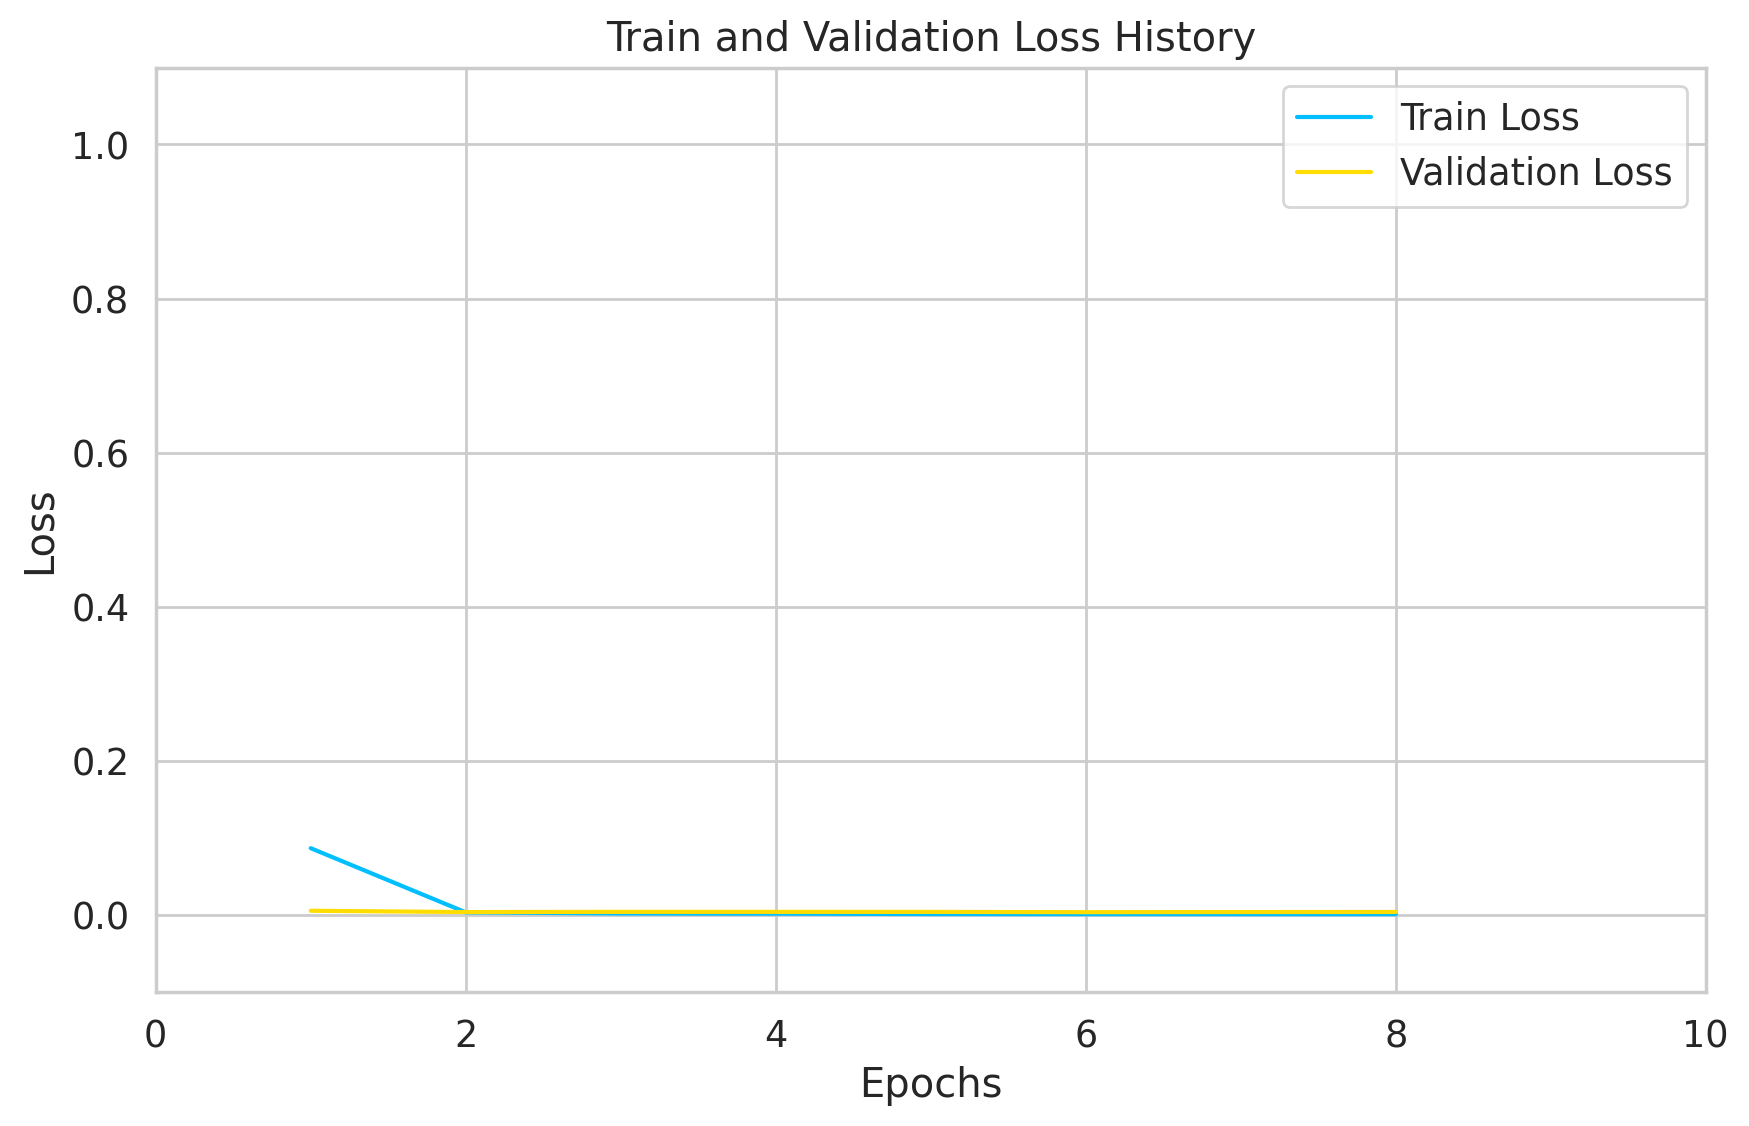

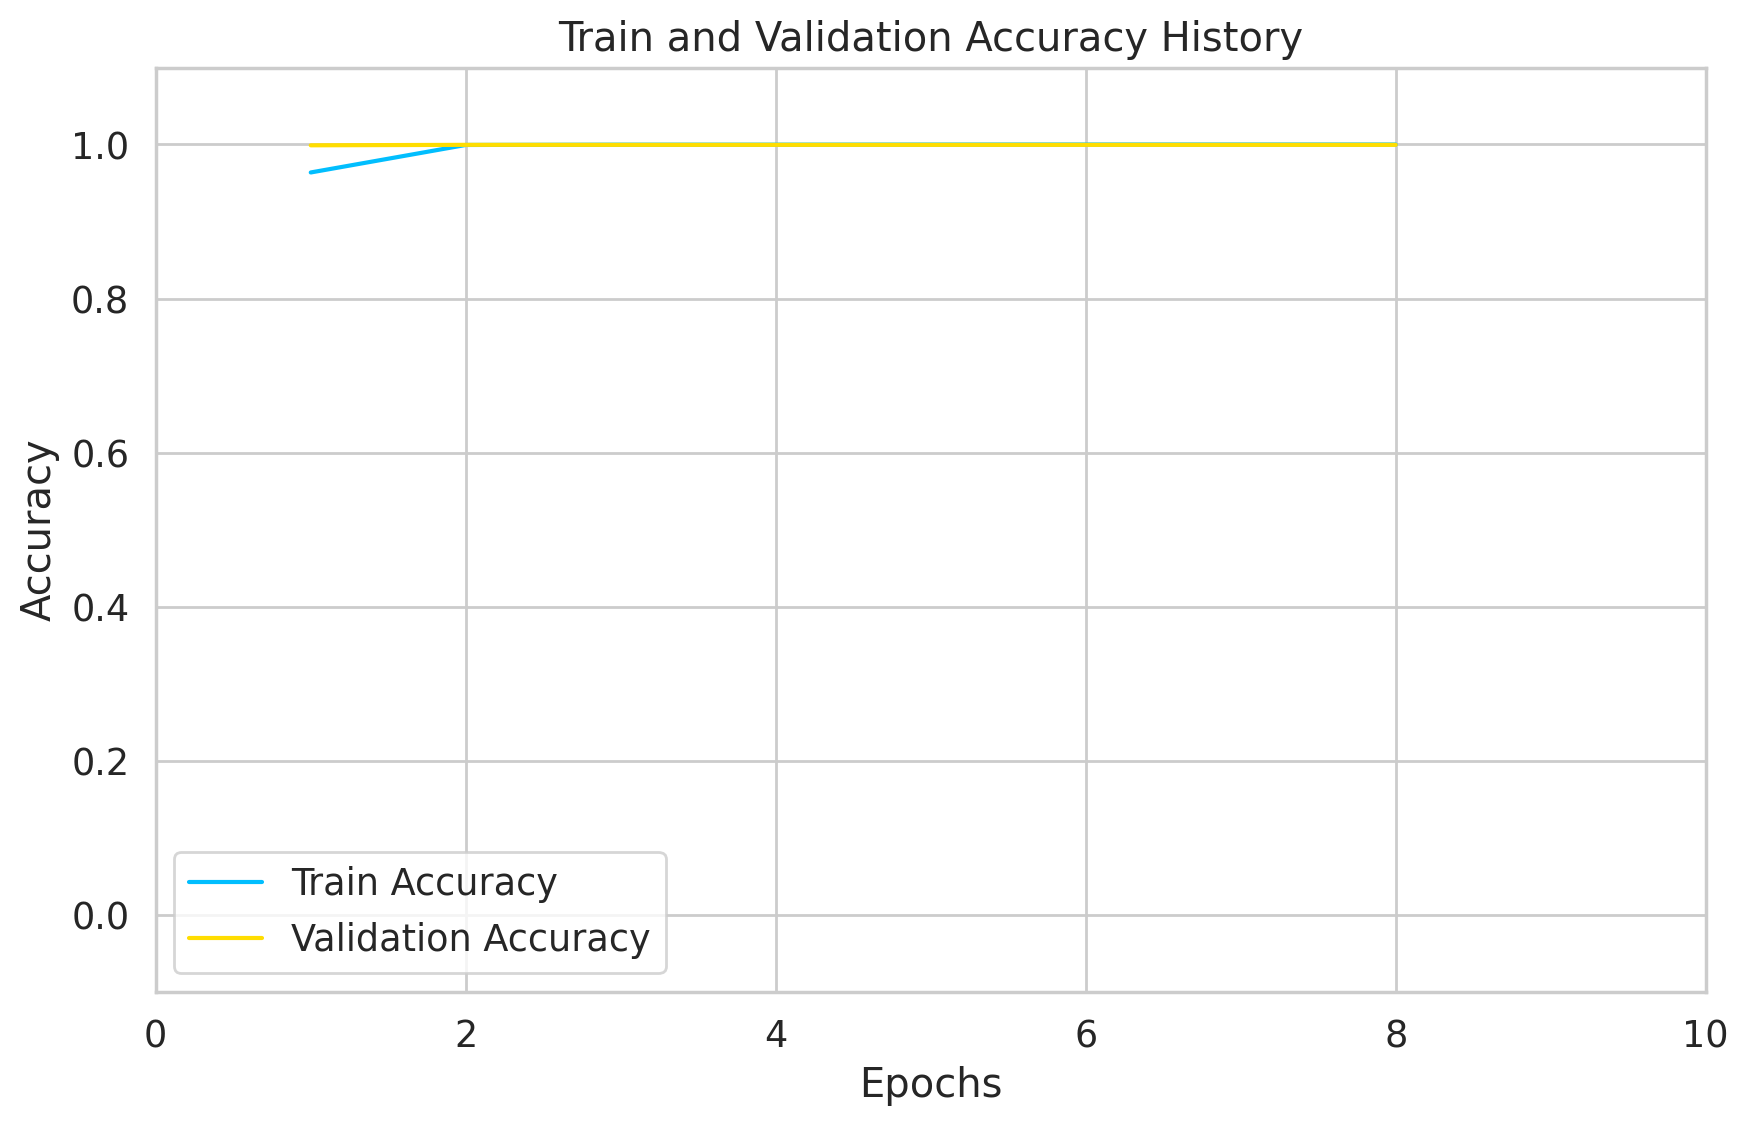

Testing: 100%|██████████| 105/105 [00:23<00:00,  4.56it/s]

Test Loss: 0.0051
Test Accuracy: 0.9993
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3122
           1       1.00      1.00      1.00      3582

    accuracy                           1.00      6704
   macro avg       1.00      1.00      1.00      6704
weighted avg       1.00      1.00      1.00      6704



In [24]:
# Use the best parameters to retrain the model
best_params = trial.params
model_name = best_params['model_name']
batch_size = best_params['batch_size']
learning_rate = best_params['learning_rate']
epochs = best_params['epochs']
weight_decay = best_params['weight_decay']
warmup_steps = best_params['warmup_steps']


# Initialize variables for tracking the best model
best_val_loss = float('inf')
best_model_state = None

train_dataloader = create_data_loader(tensor_data[model_name]['train'][0], tensor_data[model_name]['train'][1], tensor_data[model_name]['train'][2], batch_size)
val_dataloader = create_data_loader(tensor_data[model_name]['val'][0], tensor_data[model_name]['val'][1], tensor_data[model_name]['val'][2], batch_size)

model = load_model_and_tokenizer(model_name)[1]
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

total_steps = len(train_dataloader) * epochs
scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{epochs}'):
        batch = [b.to(device) for b in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, attention_mask=mask).logits
        loss = nn.CrossEntropyLoss()(preds, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        correct_predictions += (torch.argmax(preds, dim=1) == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate train loss
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Calculate train accuracy
    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Validation Epoch {epoch + 1}/{epochs}'):
            batch = [b.to(device) for b in batch]
            sent_id, mask, labels = batch
            preds = model(sent_id, attention_mask=mask).logits
            
            loss = nn.CrossEntropyLoss()(preds, labels)
            total_loss += loss.item()
            
            correct_predictions += (torch.argmax(preds, dim=1) == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate validation loss
    avg_val_loss = total_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    # Calculate validation accuracy
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Check if the current validation loss is the best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()  # Save the model state

# After training, save the best model
torch.save(best_model_state, f'best_model_{model_name}.pth')
print(f'Best model saved with validation loss: {best_val_loss:.4f}')        
        
# Plotting Train/Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss History')
plt.legend()
plt.xlim([0, 10]);
plt.ylim([-0.1, 1.1]);
plt.show()

# Plotting Train/Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy History')
plt.legend()
plt.xlim([0, 10]);
plt.ylim([-0.1, 1.1]);
plt.show()
    
# Testing Phase
test_dataloader = create_data_loader(tensor_data[model_name]['test'][0], tensor_data[model_name]['test'][1], tensor_data[model_name]['test'][2], batch_size)

model.eval()
test_preds, test_labels = [], []
test_loss = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Testing'):
        batch = [b.to(device) for b in batch]
        sent_id, mask, labels = batch
        preds = model(sent_id, attention_mask=mask).logits
        
        # Calculate loss
        loss = nn.CrossEntropyLoss()(preds, labels)
        test_loss += loss.item()
        
        test_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Average test loss
avg_test_loss = test_loss / len(test_dataloader)
print(f'Test Loss: {avg_test_loss:.4f}')

# Calculate test accuracy
test_accuracy = np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Classification Report
print(classification_report(test_labels, test_preds))

In [25]:
print(model)                                                                                                                                                                                

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

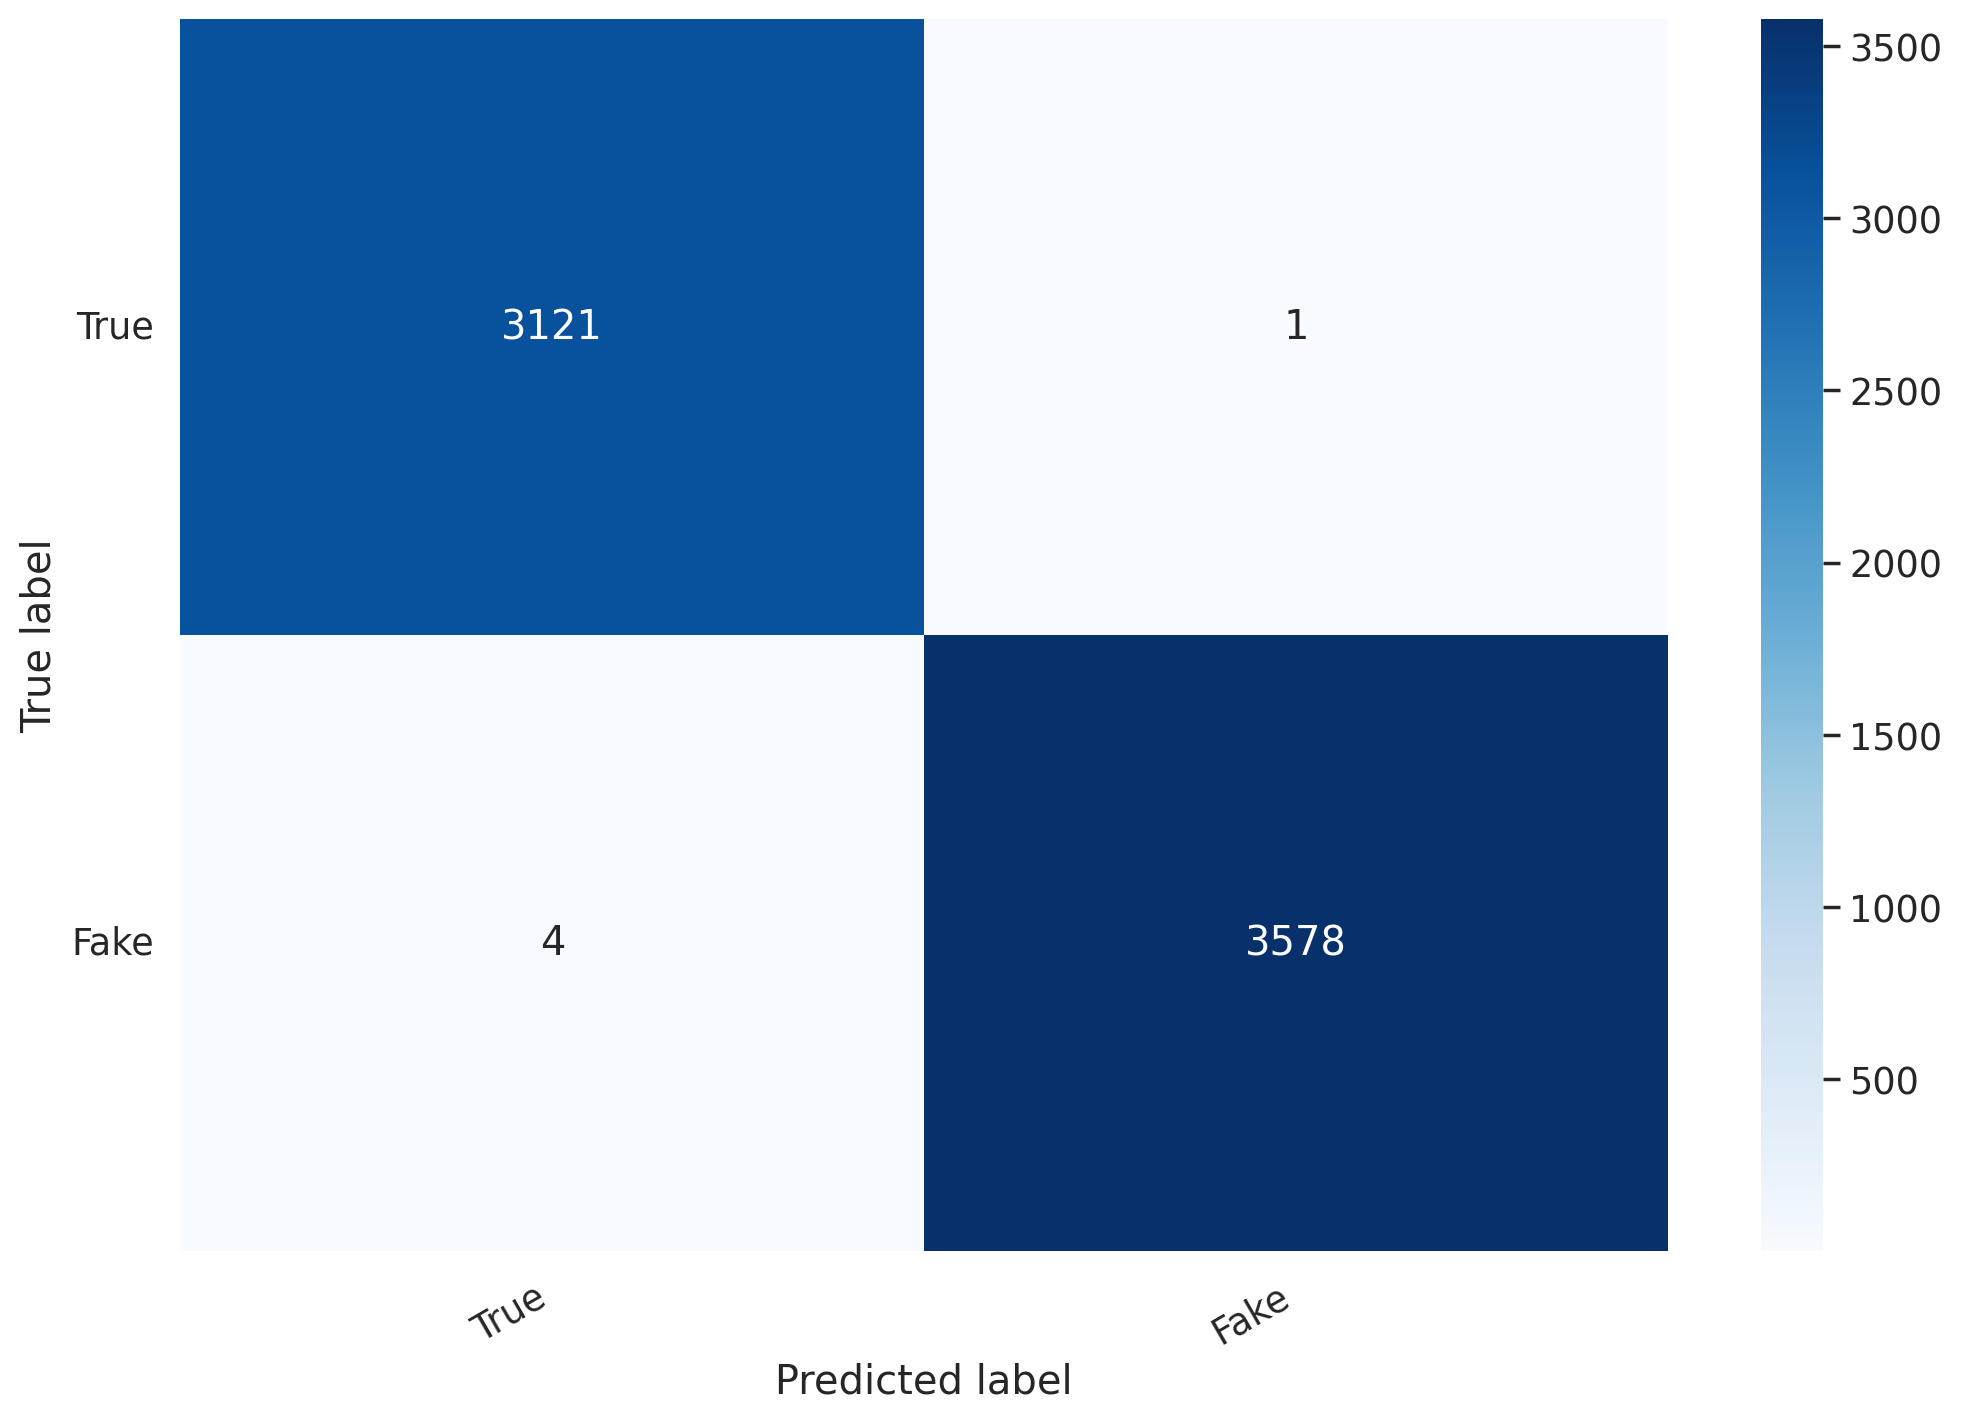

In [26]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');

class_names = ['True', 'Fake']
cm = confusion_matrix(test_labels, test_preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [27]:
# Function to predict labels for unseen data
def predict_unseen_data(model, tokenizer, unseen_texts, max_length=MAX_LENGTH):
    model.eval()
    tokens = tokenizer.batch_encode_plus(unseen_texts, max_length=max_length, padding='max_length', truncation=True)
    
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)

    with torch.no_grad():
        preds = model(input_ids, attention_mask=attention_mask).logits
        predictions = torch.argmax(preds, dim=1).cpu().numpy()
    
    return predictions

# Predictions on unseen data
unseen_data = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",
    "Trump administration issues new rules on U.S. visa waivers"
]

# Load the best tokenizer
tokenizer = load_model_and_tokenizer(model_name)[0]

# Make predictions
predictions = predict_unseen_data(model, tokenizer, unseen_data)
print("Predictions on unseen data:", predictions)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions on unseen data: [1 1 0 0]


------

# Load directly from the saved best model to be used for prediction

In [2]:
import torch
from transformers import BertForSequenceClassification, BertTokenizerFast

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 1: Load the model structure
model_name = 'bert-base-cased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Step 2: Load the saved state dictionary
model.load_state_dict(torch.load('best_model_bert-base-cased.pth', map_location=device))

# Step 3: Move the model to the specified device
model.to(device)

# Step 4 (Optional): Load the tokenizer if needed for inference
tokenizer = BertTokenizerFast.from_pretrained(model_name)

print("Model and tokenizer are loaded successfully and ready for inference!")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/3d/c6dcks490c7062j17wf5zk5m0000gn/T/ipykernel_14232/3520395039.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Model and tokenizer are loaded successfully and ready for inference!


In [11]:
MAX_LENGTH = 128

# Function to load tokenizer and model
def load_model_and_tokenizer(model_name):
    if model_name == 'distilbert':
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    elif model_name == 'distilbert-cased':
        tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
    elif model_name == 'bert-base-cased':
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
        model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
    elif model_name == 'bert-base-uncased':
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    return tokenizer, model

# Function to predict labels for unseen data
def predict_unseen_data(model, tokenizer, unseen_texts, max_length=MAX_LENGTH):
    model.eval()
    tokens = tokenizer.batch_encode_plus(unseen_texts, max_length=max_length, padding='max_length', truncation=True)
    
    input_ids = torch.tensor(tokens['input_ids']).to(device)
    attention_mask = torch.tensor(tokens['attention_mask']).to(device)

    with torch.no_grad():
        preds = model(input_ids, attention_mask=attention_mask).logits
        predictions = torch.argmax(preds, dim=1).cpu().numpy()
    
    return predictions

# Predictions on unseen data
unseen_data = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",
    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",
    "Trump administration issues new rules on U.S. visa waivers",
    "US presidential election updates: Kamala Harris delivers closing address while Trump and Biden talk ‘garbage’",
    "How X users can earn thousands from US election misinformation and AI images",
    "Are fears about online misinformation in the US election overblown? The evidence suggests they might be",
    "Dominion Voting Systems Algorithm Flipped 3% of Trump Votes to Biden in All States",
    "Deepfake of President Biden Used in Election Disinformation Campaign"
]

# Load the best tokenizer
tokenizer = load_model_and_tokenizer(model_name)[0]

# Make predictions
predictions = predict_unseen_data(model, tokenizer, unseen_data)
print("Predictions on unseen data:", predictions)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions on unseen data: [1 1 0 0 0 0 0 1 1]
